In [213]:
from dro.modules import mean_fluorescence
from visual_behavior.data_access import loading
from visual_behavior import database as db
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy import interpolate
from tqdm import tqdm
from scipy import stats
import seaborn as sns
from multiprocessing import Pool

In [14]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
ophys_experiment_table = loading.get_filtered_ophys_experiment_table(release_data_only=True).reset_index()

In [247]:
def get_corr(mean_f):
    if (mean_f['cumulative_volume']==0).all():
        x = 0.001*np.random.randn(len(mean_f['cumulative_volume']))
    else:
        x = mean_f['cumulative_volume']
    y = mean_f['mean_fluorescence'].rolling(window = 480, center=True, min_periods=0).mean()
#     y = mean_f['mean_fluorescence']
    corr = stats.pearsonr(x, y)
    return corr

def make_plot(mean_f):
    fig,ax = plt.subplots(2, 1, sharex=True, figsize = (6,6))
    ax[0].plot(
        mean_f['timestamps'],
        mean_f['mean_fluorescence']
    )
    ax[0].plot(
        mean_f['timestamps'],
        mean_f['mean_fluorescence'].rolling(window = 480, center=True, min_periods=0).mean()
    )

    ax[1].plot(
        mean_f['timestamps'],
        mean_f['cumulative_volume']
    )
    
    corr = get_corr(mean_f)
    ax[0].set_title('r = {:0.3f}, p = {:0.3f}'.format(corr[0], corr[1]))
    ax[0].set_ylabel('Mean Fluorescence')
    ax[1].set_ylabel('cumulative volume of water (mL)')
    ax[1].set_xlabel('time')
    ax[0].legend(['single frame average','rolling mean'])
    fig.tight_layout()
    return fig, ax

In [207]:
def get_corr_dict(oeid):
    oeid = int(oeid)
    try:
        mean_f = mean_fluorescence.retrieve_mean_fluorescence(oeid)
        corr = get_corr(mean_f)
        corr_dict = {
            'oeid':oeid,
            'r':corr[0],
            'p':corr[1],
            'cumulative_volume': mean_f['cumulative_volume'].max()
        }
    except:
        corr_dict = {
            'oeid':oeid,
            'r':np.nan,
            'p':np.nan,
            'cumulative_volume': np.nan
        }
    corr_dict.update(ophys_experiment_table.query('ophys_experiment_id == {}'.format(oeid)).iloc[0].to_dict())
    return corr_dict

In [215]:
%%time
with Pool(32) as pool:
    corr_df = pd.DataFrame(pool.map(get_corr_dict, ophys_experiment_table['ophys_experiment_id'].unique()))

CPU times: user 299 ms, sys: 2.11 s, total: 2.41 s
Wall time: 34 s


In [218]:
corr_df['session_type_simple'] = corr_df['session_type'].map(lambda st: st.split('_')[0] + '_' + st.split('_')[1])

In [287]:
corr_df['equipment_name_simple'] = corr_df['equipment_name'].map(lambda st: st.split('.')[0])
corr_df['equipment_name_simple'].unique()

array(['MESO', 'CAM2P'], dtype=object)

In [232]:
cre_lines = np.sort(corr_df['cre_line'].unique())

<IPython.core.display.Javascript object>


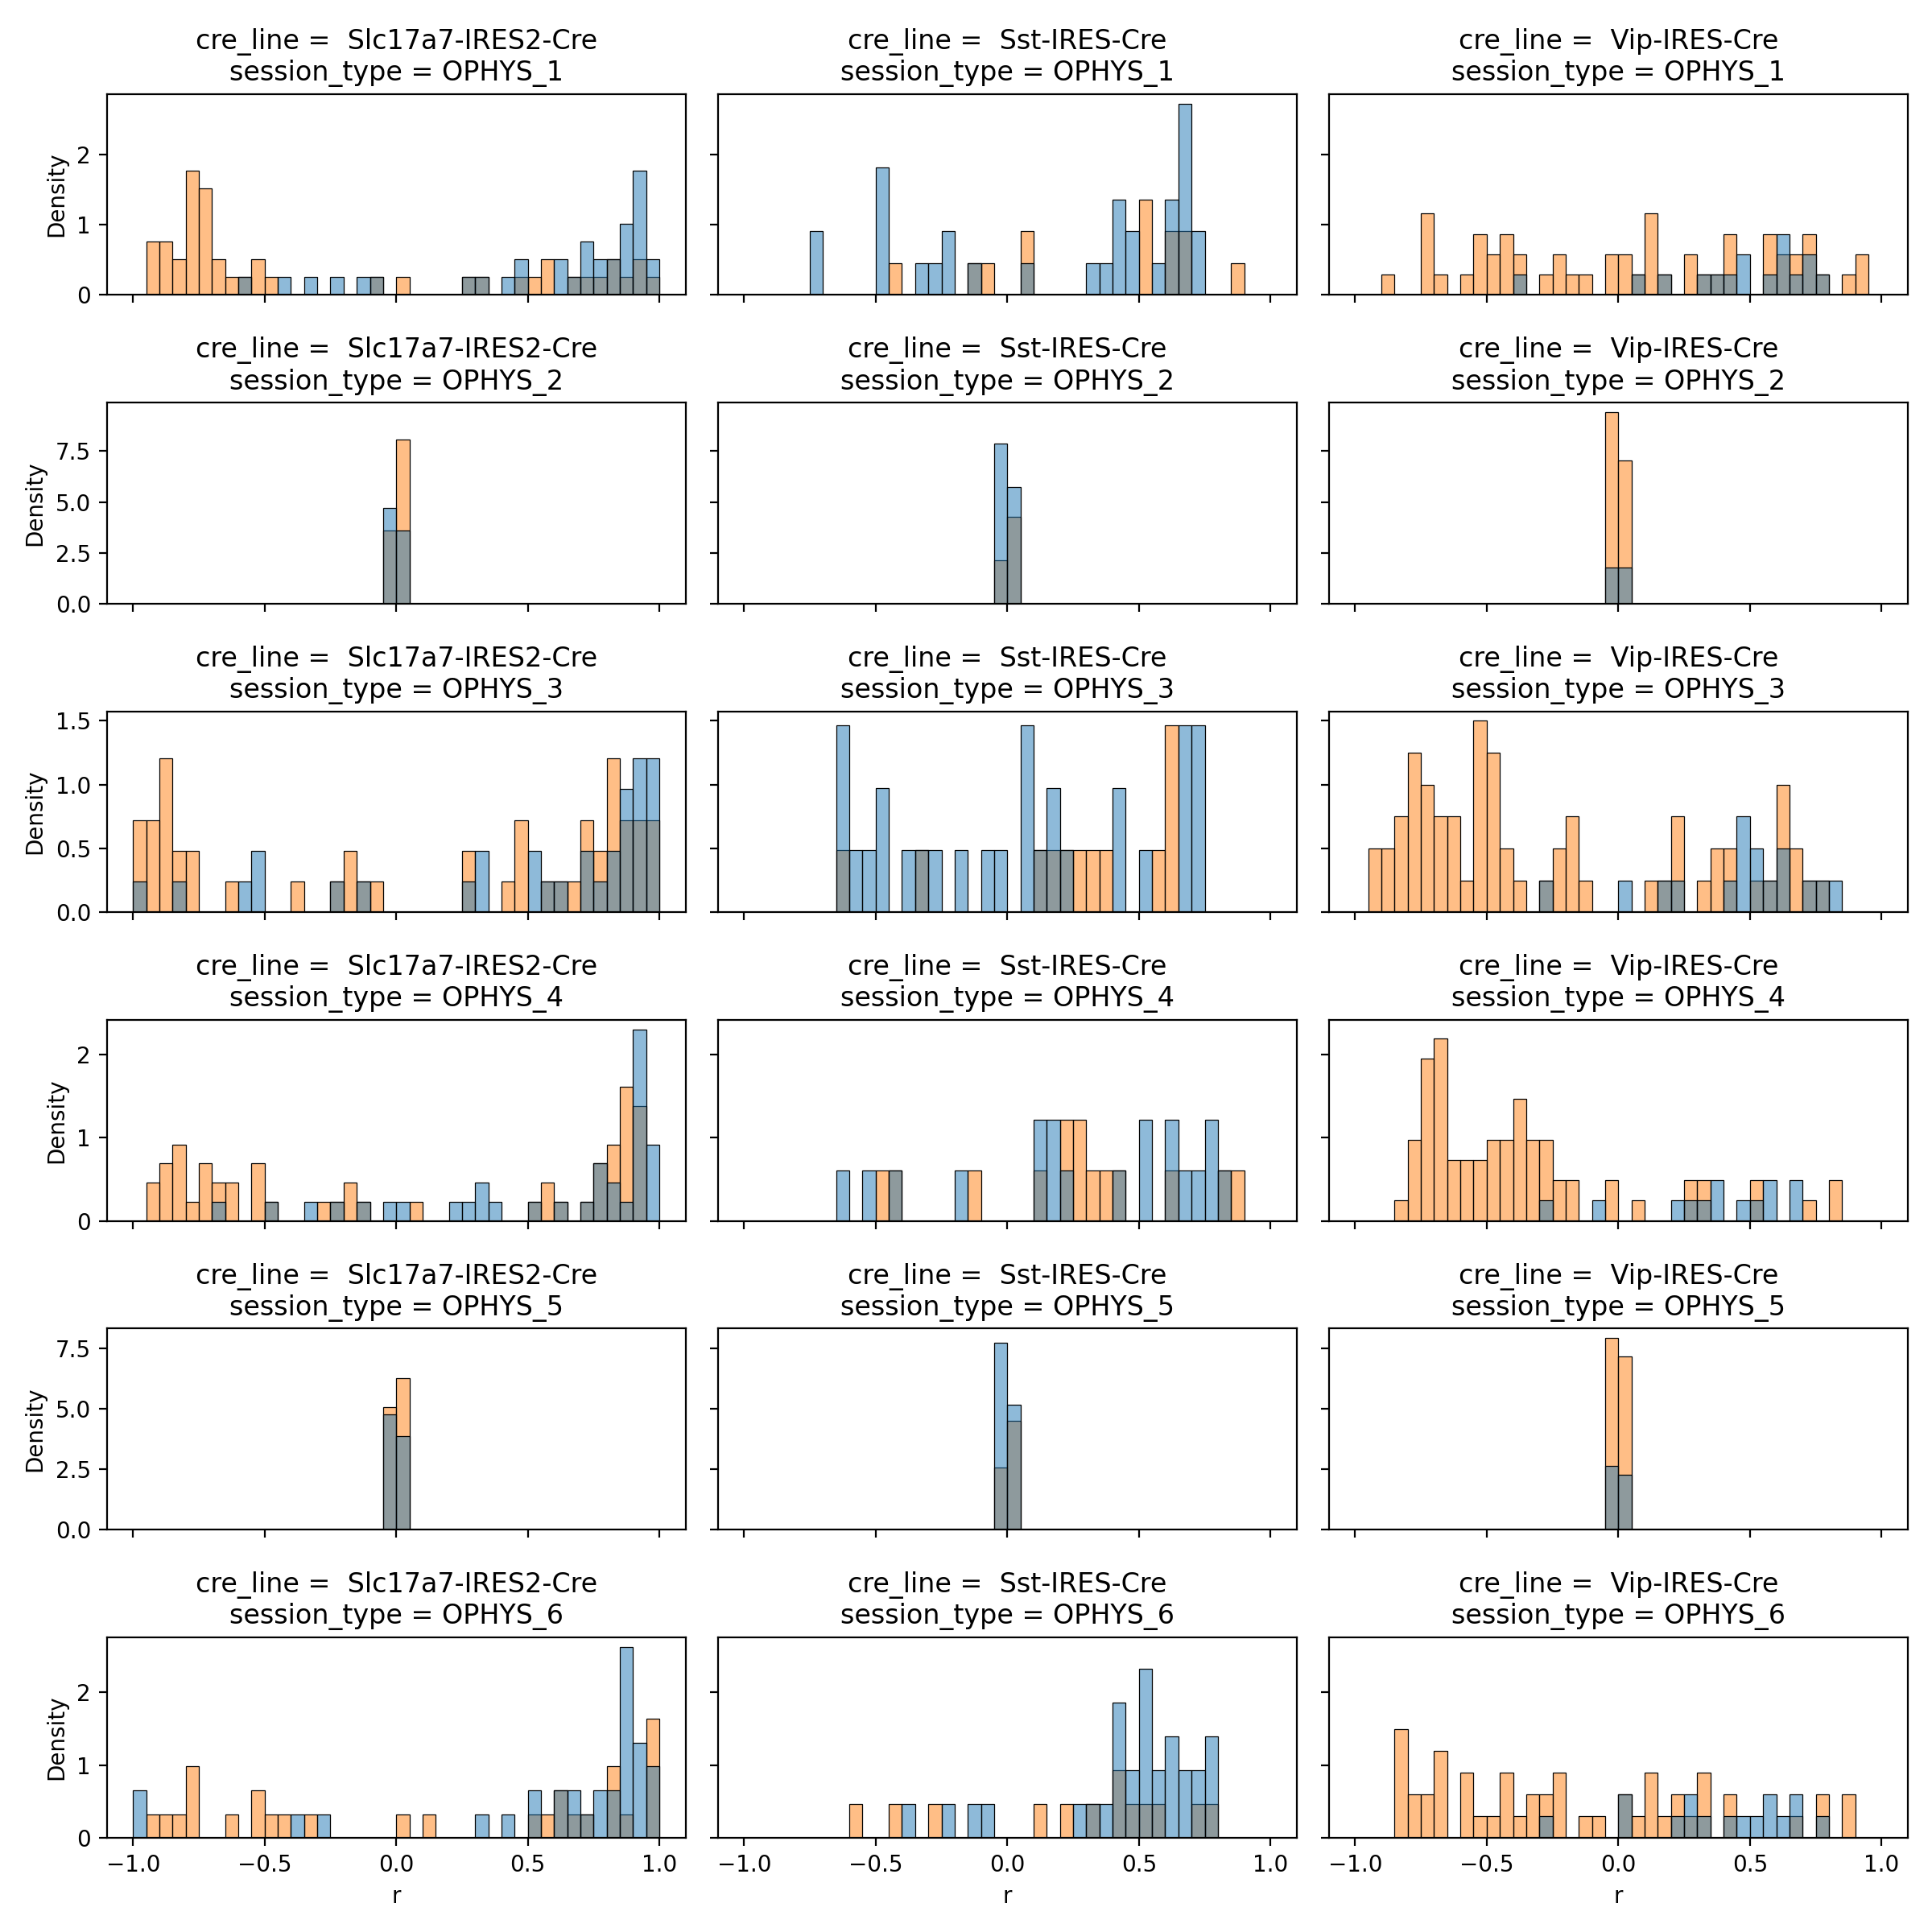

In [285]:
fig,ax = plt.subplots(6, 3, sharex=True, sharey ='row', figsize = (12,12))
binwidth = 0.05
for row, session_type_simple in enumerate(np.sort(corr_df['session_type_simple'].unique())):
    for col, cre_line in enumerate(cre_lines):
        sns.histplot(
            data = corr_df.query('session_type_simple == "{}" and cre_line == "{}"'.format(session_type_simple, cre_line)),
            x = 'r',
            bins = np.arange(-1,1+binwidth,binwidth),
            ax = ax[row, col],
            legend=False,
            stat='density',
            hue = 'equipment_name_simple',
        )
        ax[row, col].set_title('cre_line =  {}\nsession_type = {}'.format(cre_line, session_type_simple))
        
fig.tight_layout()

<IPython.core.display.Javascript object>


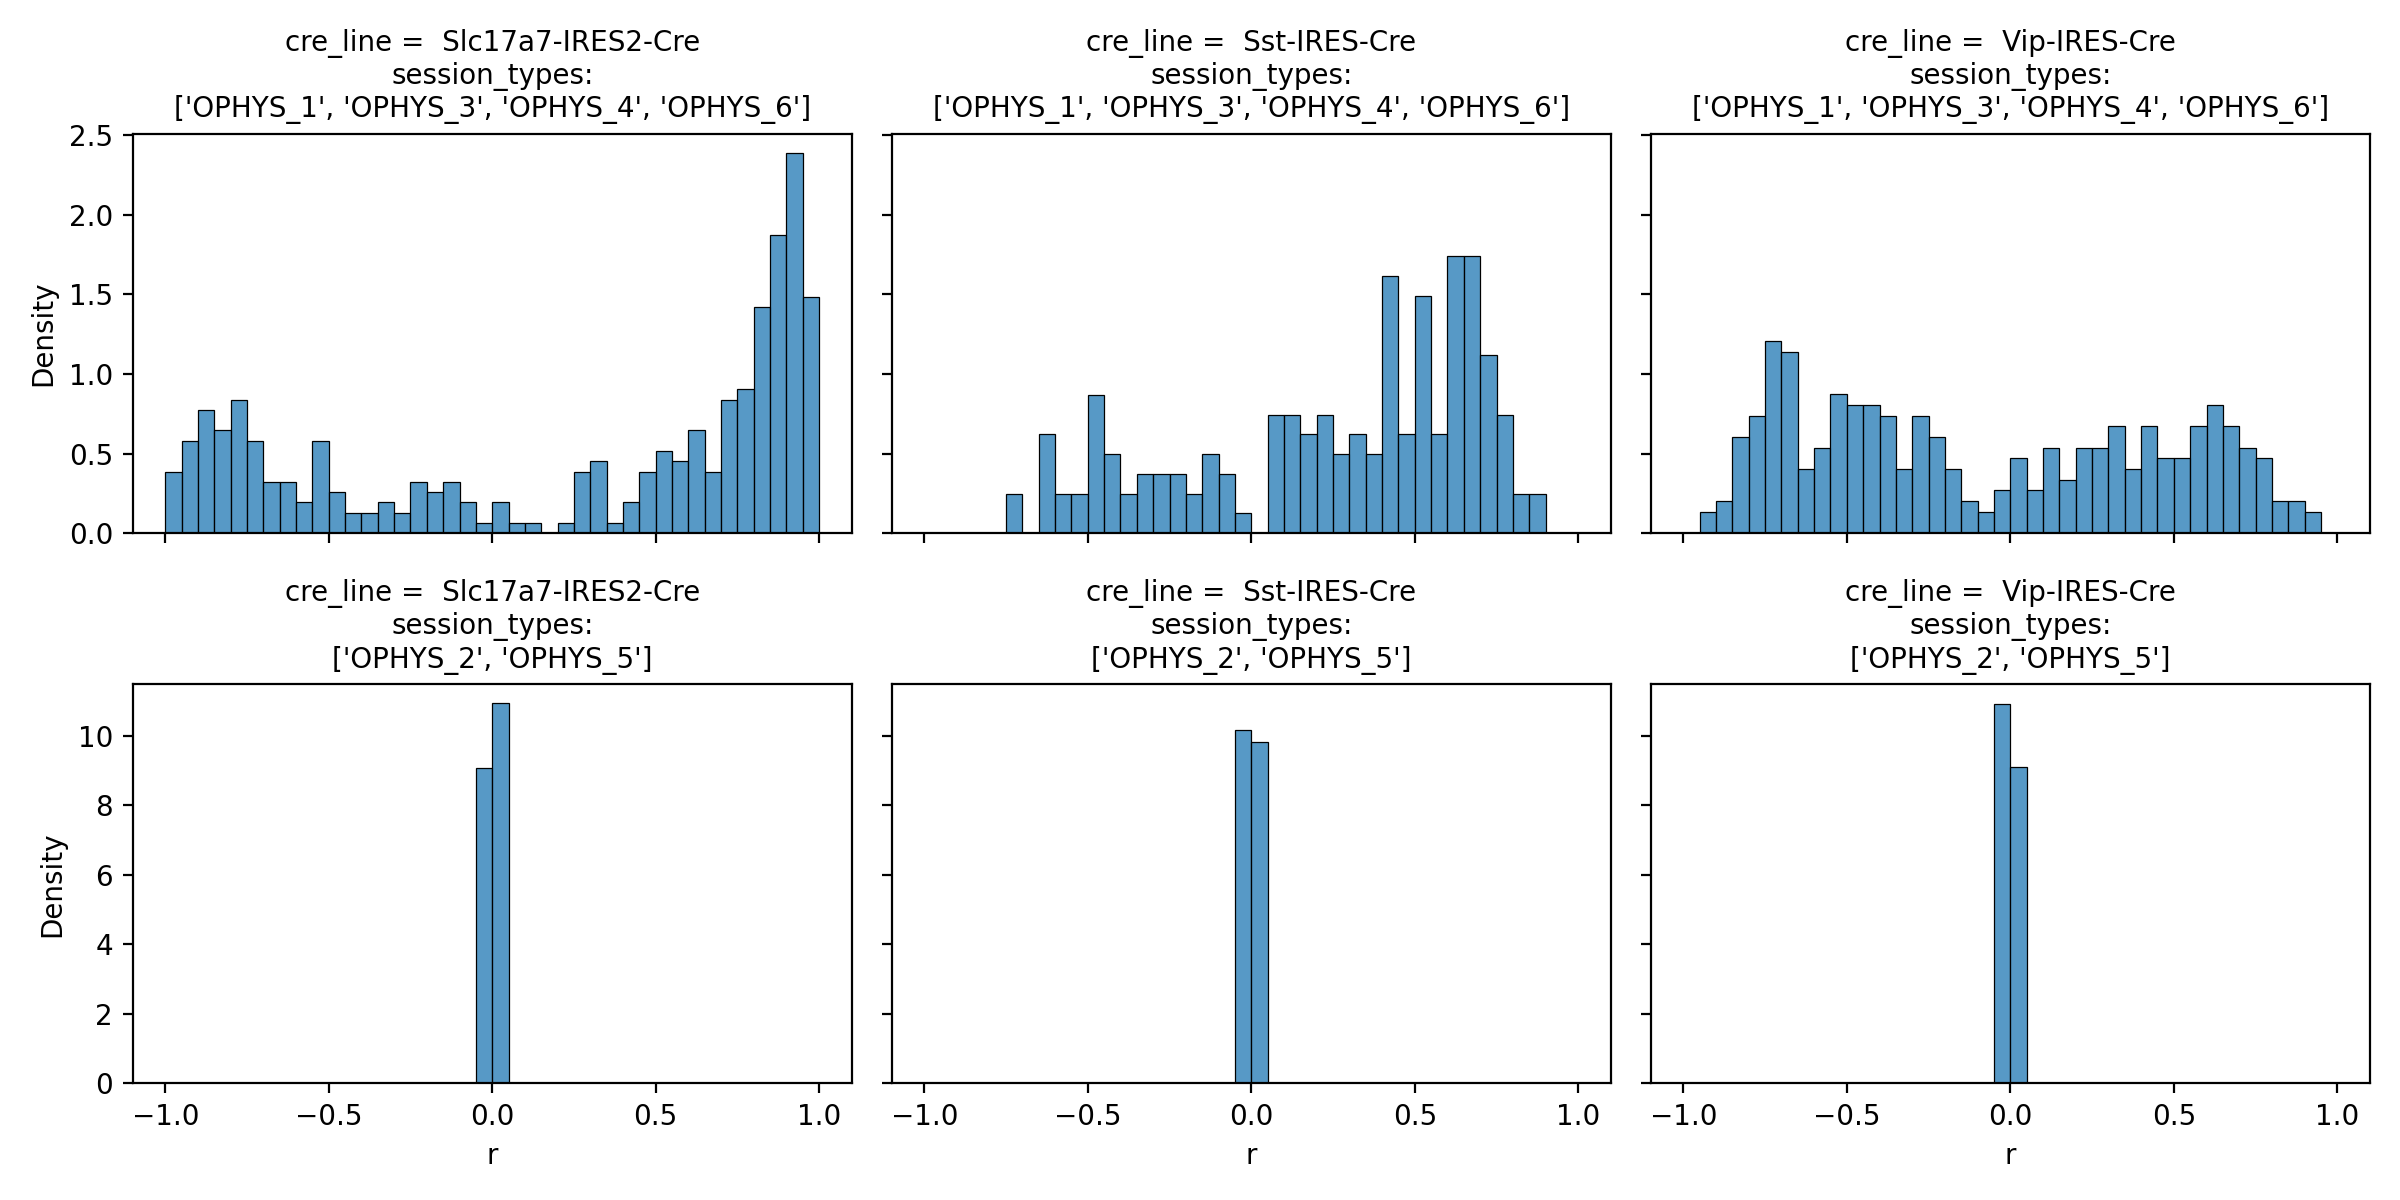

In [290]:
active_sessions = ["OPHYS_1", "OPHYS_3", "OPHYS_4", "OPHYS_6"]
passive_sessions = ["OPHYS_2", "OPHYS_5"]
fig,ax = plt.subplots(2, 3, sharex=True, sharey ='row', figsize = (12,6))
binwidth = 0.05
for row, session_type_group in enumerate([active_sessions, passive_sessions]):
    for col, cre_line in enumerate(cre_lines):
        sns.histplot(
            data = corr_df.query('session_type_simple in @session_type_group and cre_line == "{}"'.format(cre_line)),
            x = 'r',
            bins = np.arange(-1,1+binwidth,binwidth),
            ax = ax[row, col],
            legend=False,
            stat='density',
        )
        ax[row, col].set_title('cre_line =  {}\nsession_types:\n{}'.format(cre_line, session_type_group), fontsize = 10)
        
fig.tight_layout()

<IPython.core.display.Javascript object>


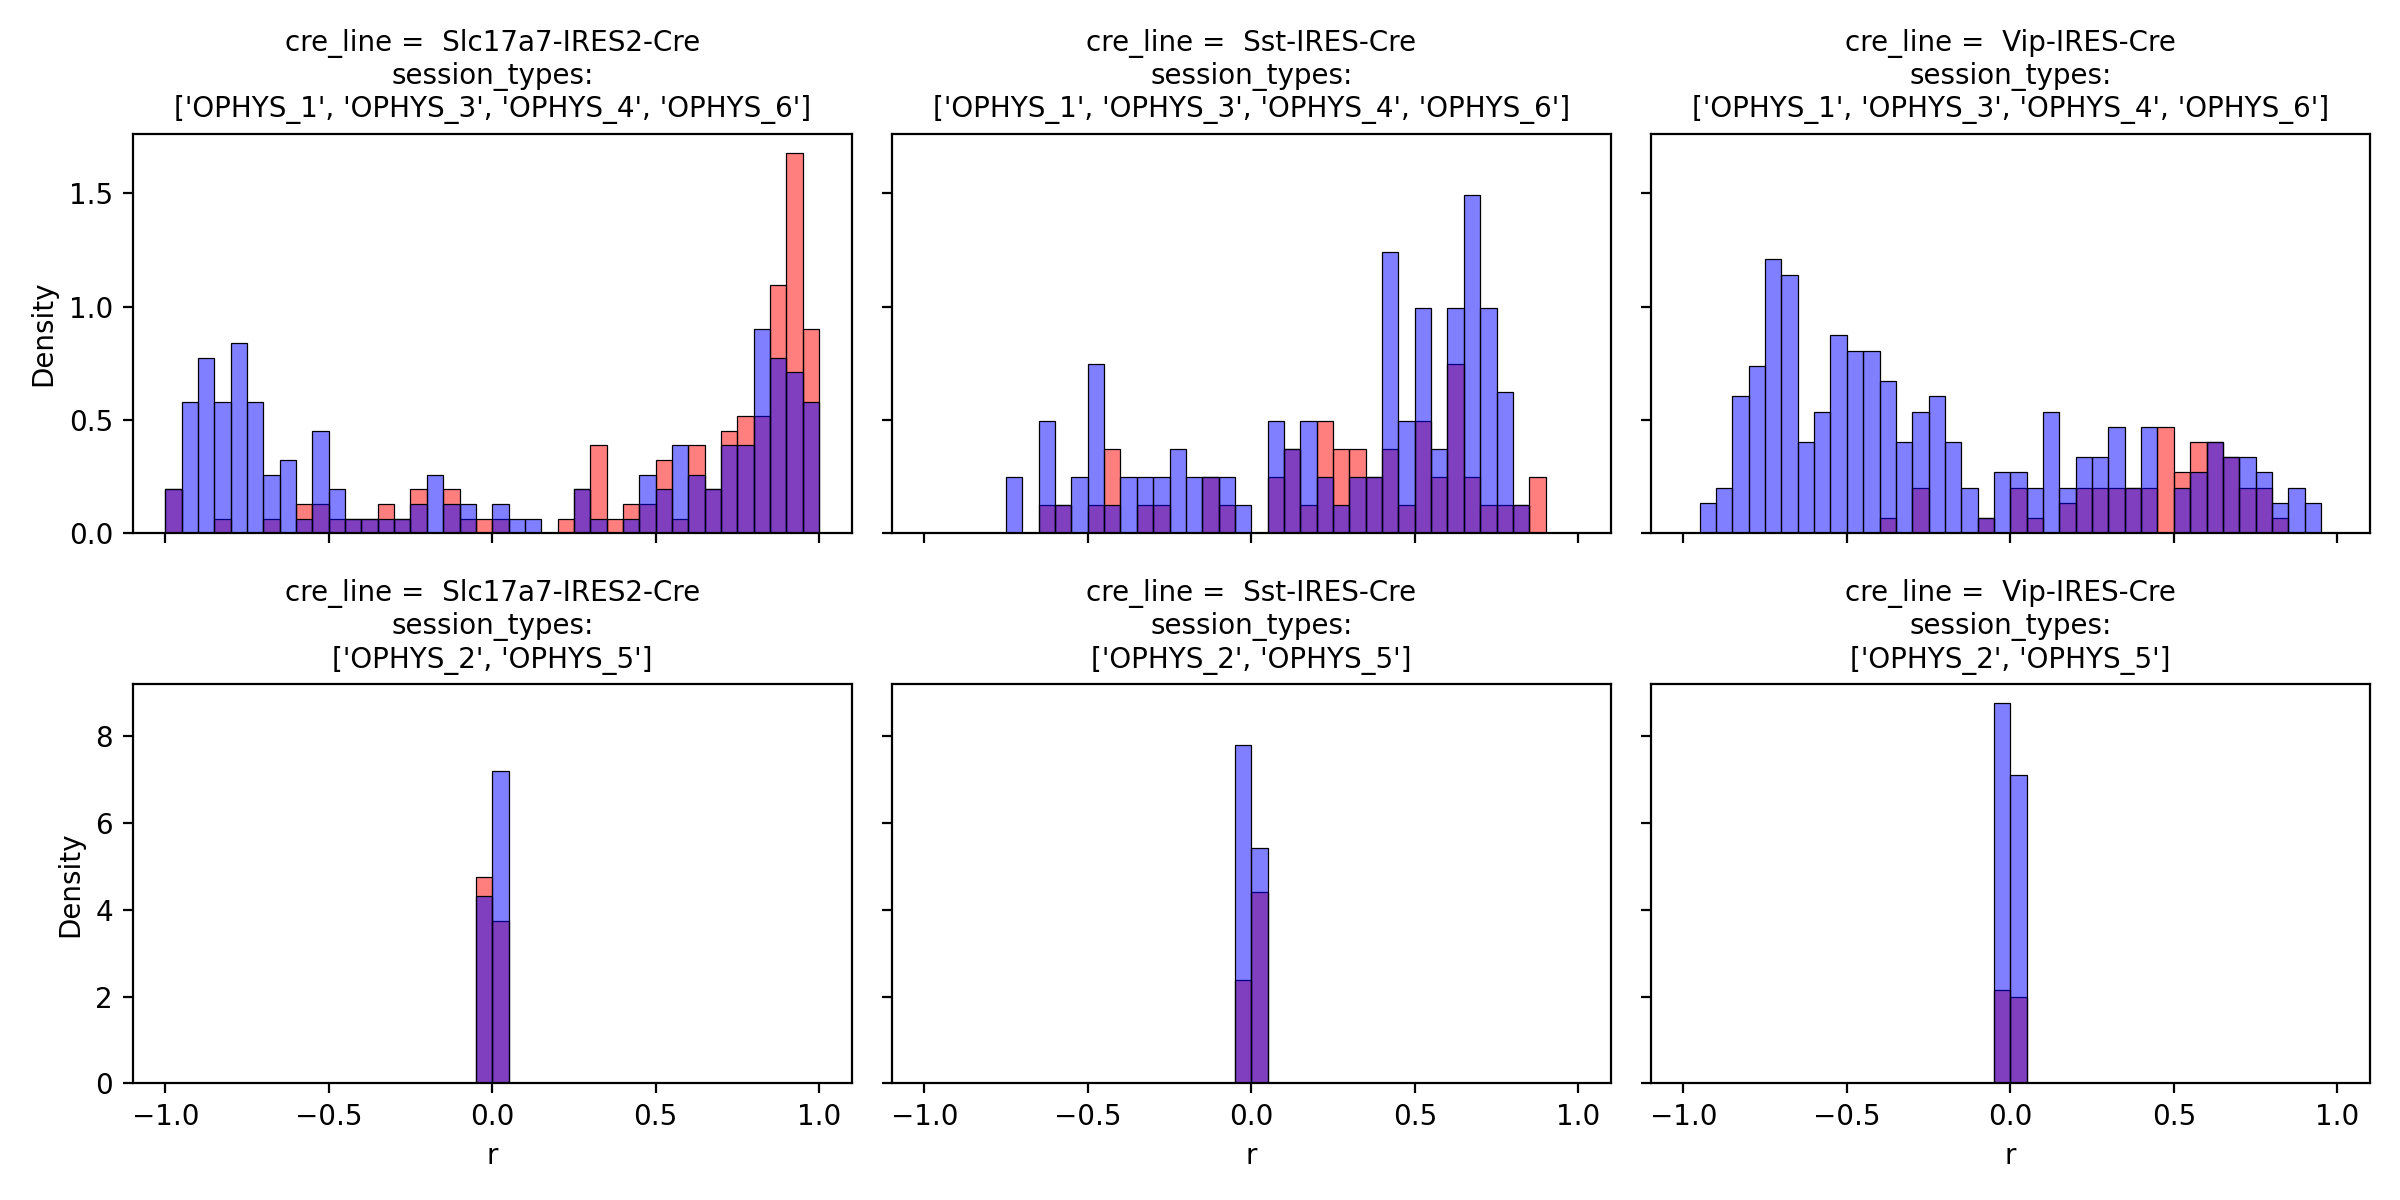

In [288]:
active_sessions = ["OPHYS_1", "OPHYS_3", "OPHYS_4", "OPHYS_6"]
passive_sessions = ["OPHYS_2", "OPHYS_5"]
fig,ax = plt.subplots(2, 3, sharex=True, sharey ='row', figsize = (12,6))
binwidth = 0.05
for row, session_type_group in enumerate([active_sessions, passive_sessions]):
    for col, cre_line in enumerate(cre_lines):
        sns.histplot(
            data = corr_df.query('session_type_simple in @session_type_group and cre_line == "{}"'.format(cre_line)),
            x = 'r',
            bins = np.arange(-1,1+binwidth,binwidth),
            ax = ax[row, col],
            legend=False,
            stat='density',
            hue = 'equipment_name_simple',
            hue_order = ['MESO', 'CAM2P'],
            palette = ['blue','red']
        )
        ax[row, col].set_title('cre_line =  {}\nsession_types:\n{}'.format(cre_line, session_type_group), fontsize = 10)
        
fig.tight_layout()

<IPython.core.display.Javascript object>


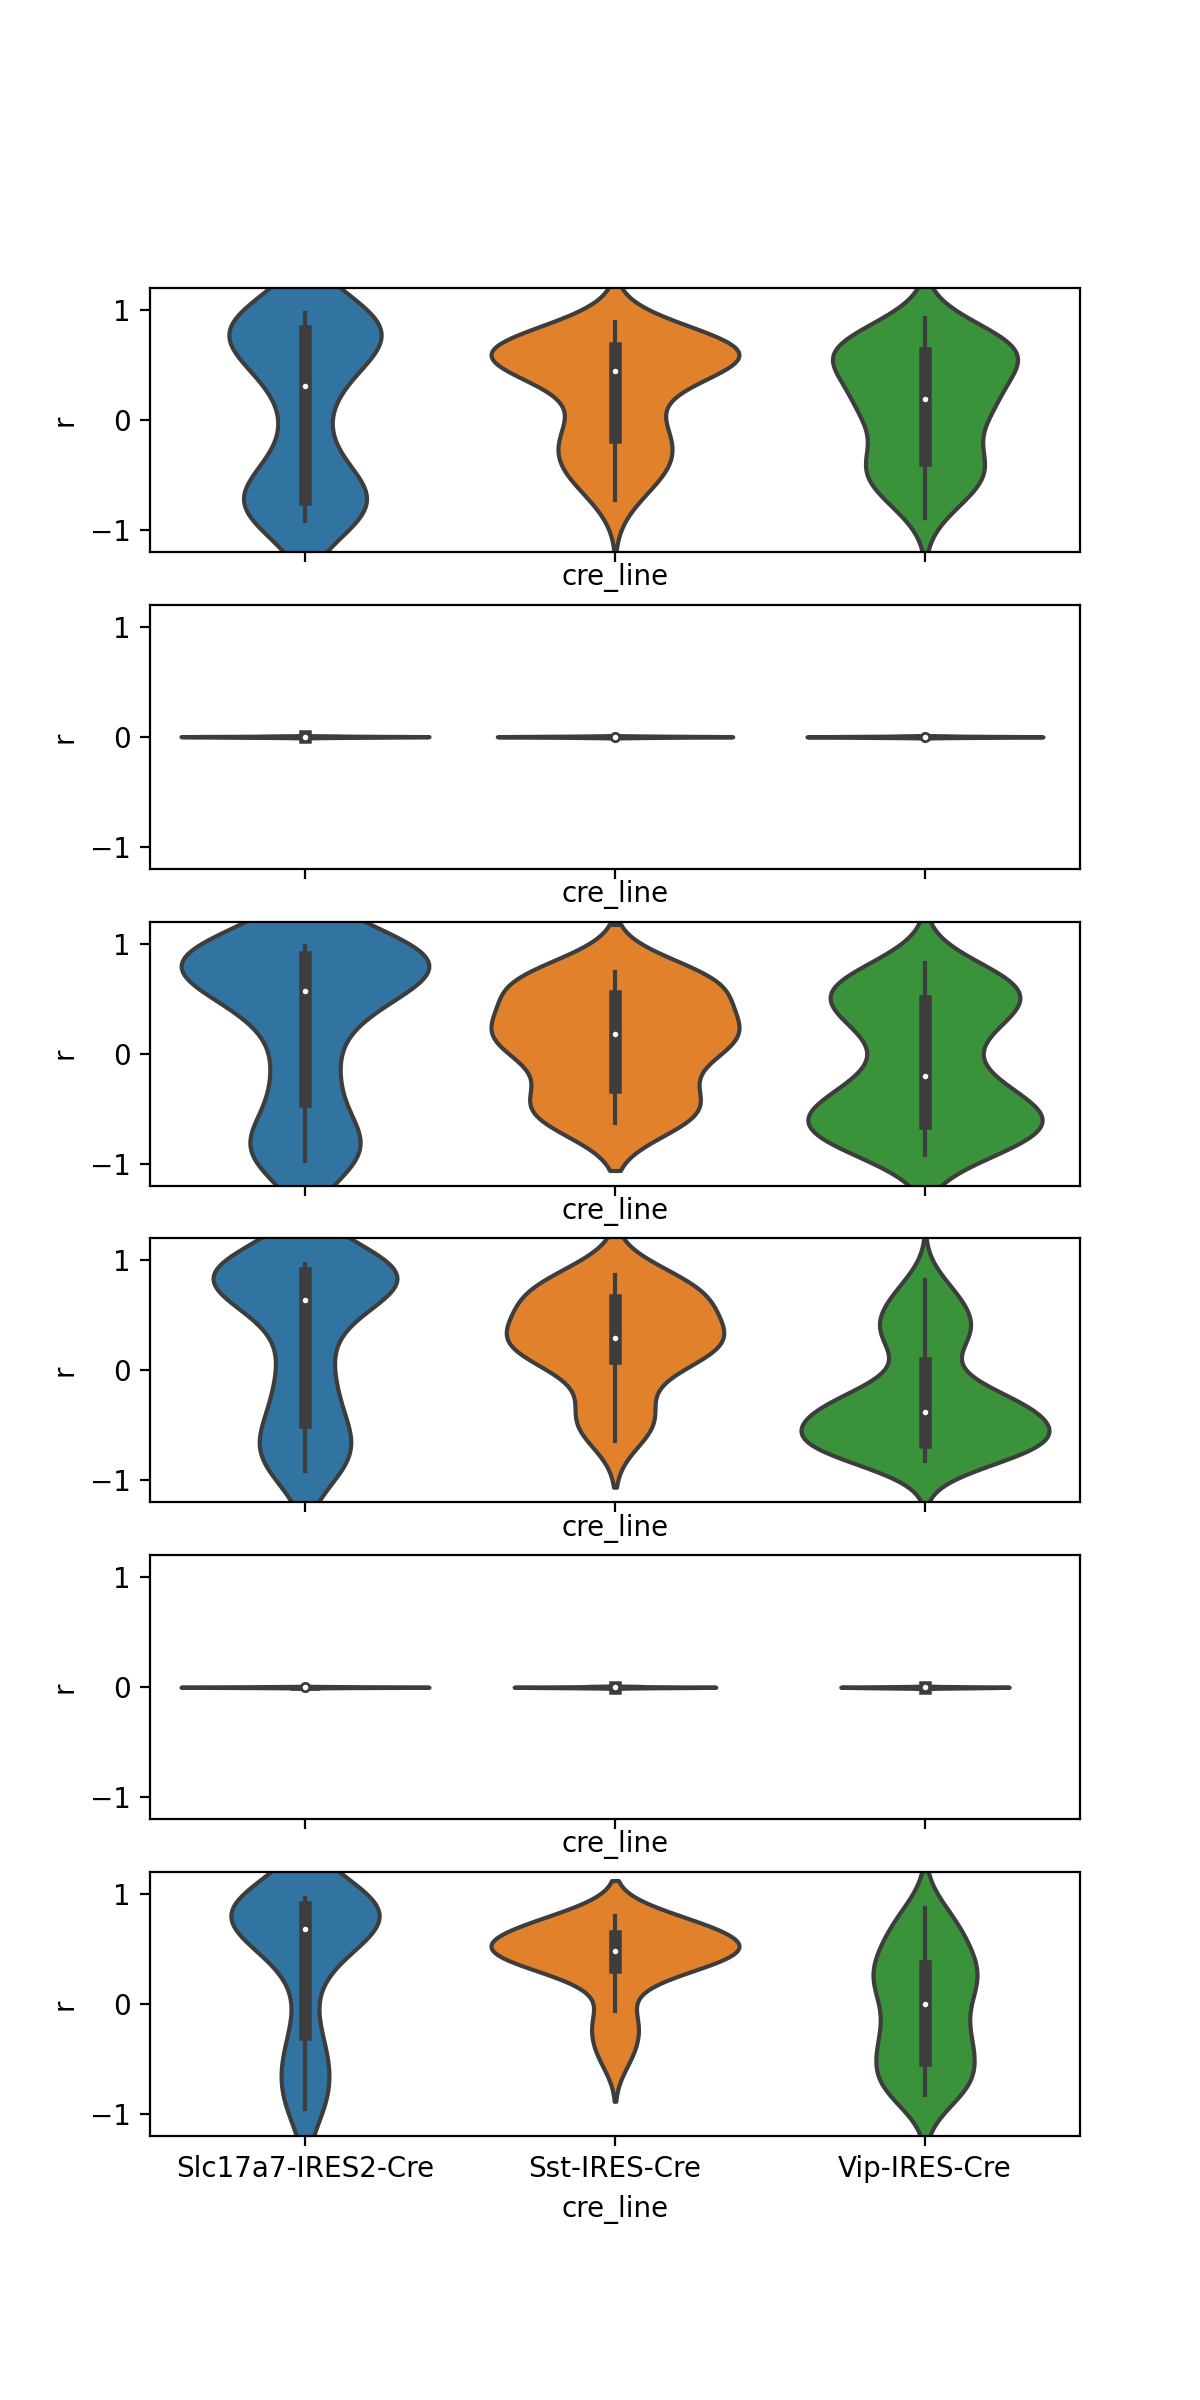

In [240]:
fig,ax = plt.subplots(6, 1, sharex=True, figsize = (6,12))
binwidth = 0.05
for row, session_type_simple in enumerate(np.sort(corr_df['session_type_simple'].unique())):
    sns.violinplot(
        data = corr_df.query('session_type_simple == "{}"'.format(session_type_simple)),
        x = 'cre_line',
        y = 'r',
        order = cre_lines,
        bins = np.arange(-1,1+binwidth,binwidth),
#         hue = 'cre_line',
        ax = ax[row],
    )
    ax[row].set_ylim(-1.2,1.2)

<IPython.core.display.Javascript object>


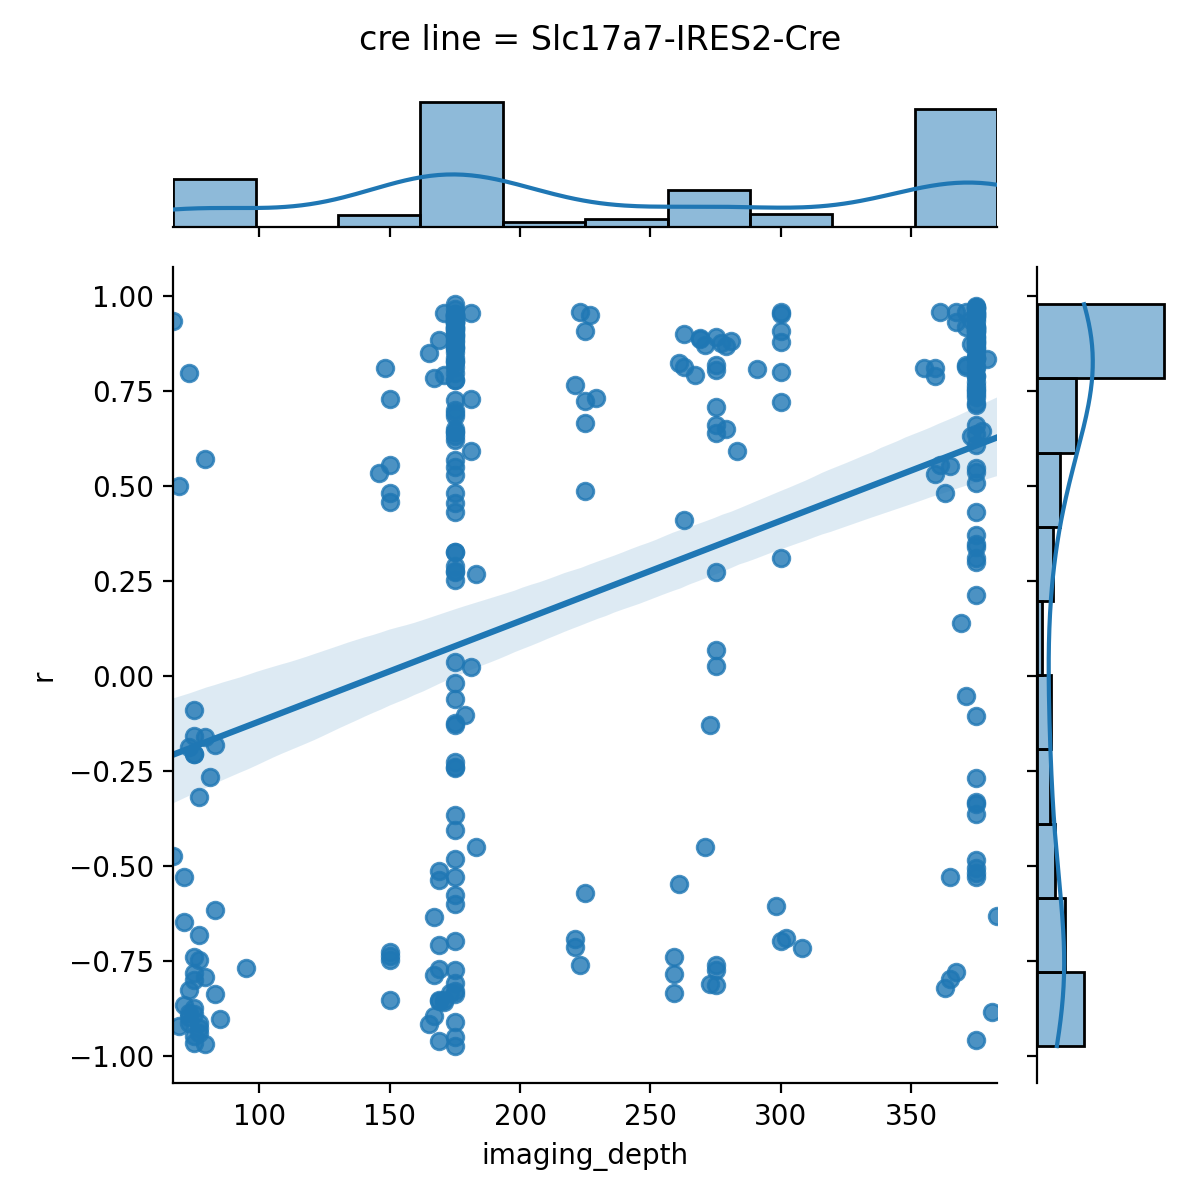

<IPython.core.display.Javascript object>


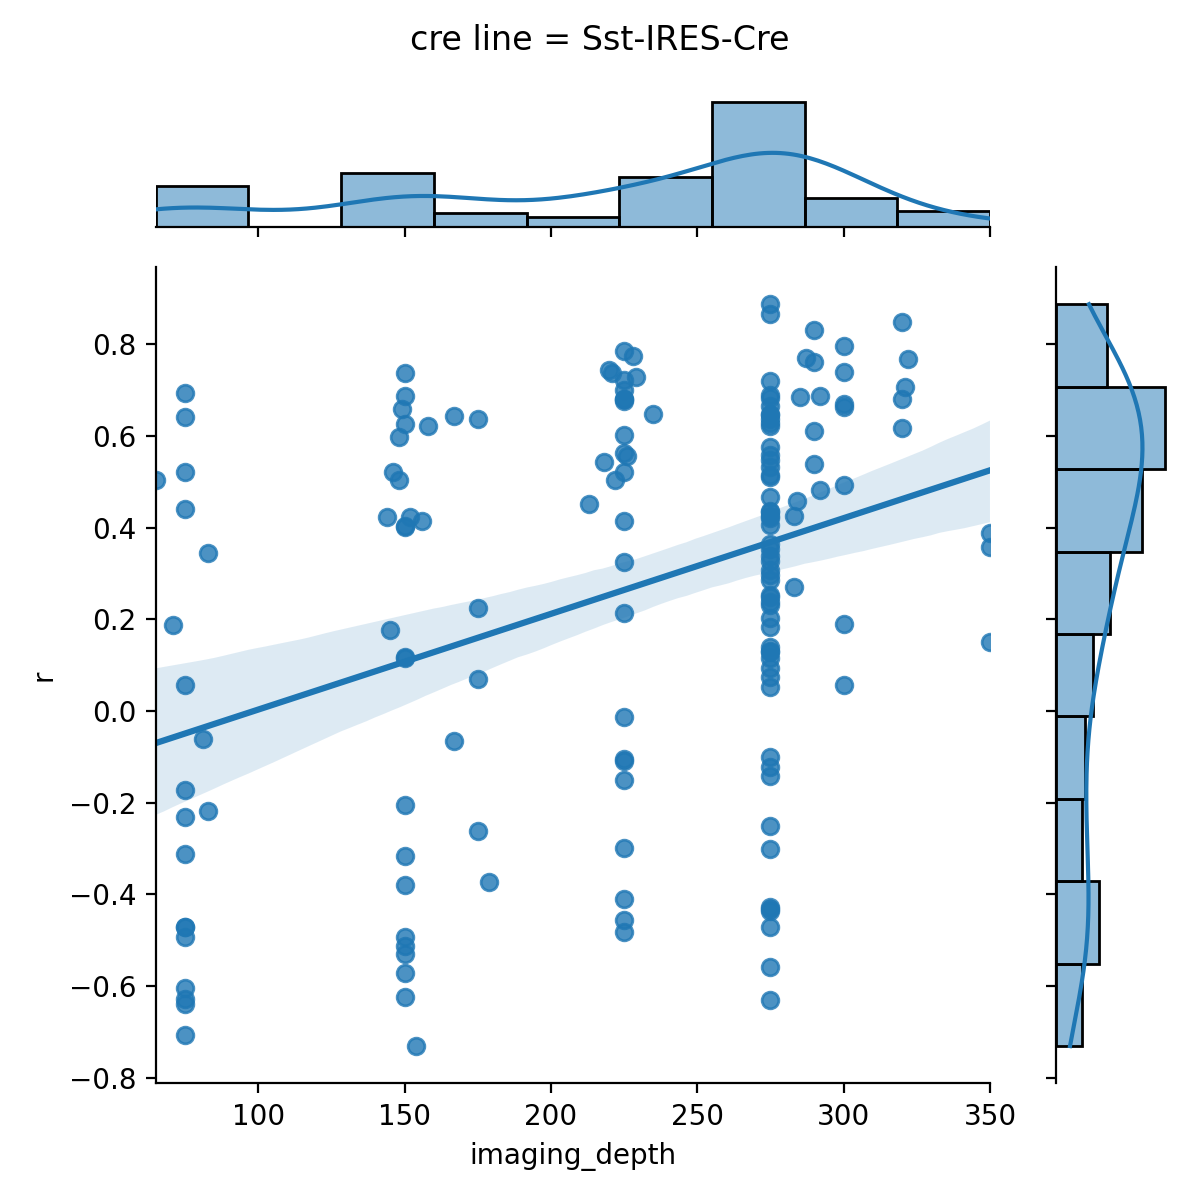

<IPython.core.display.Javascript object>


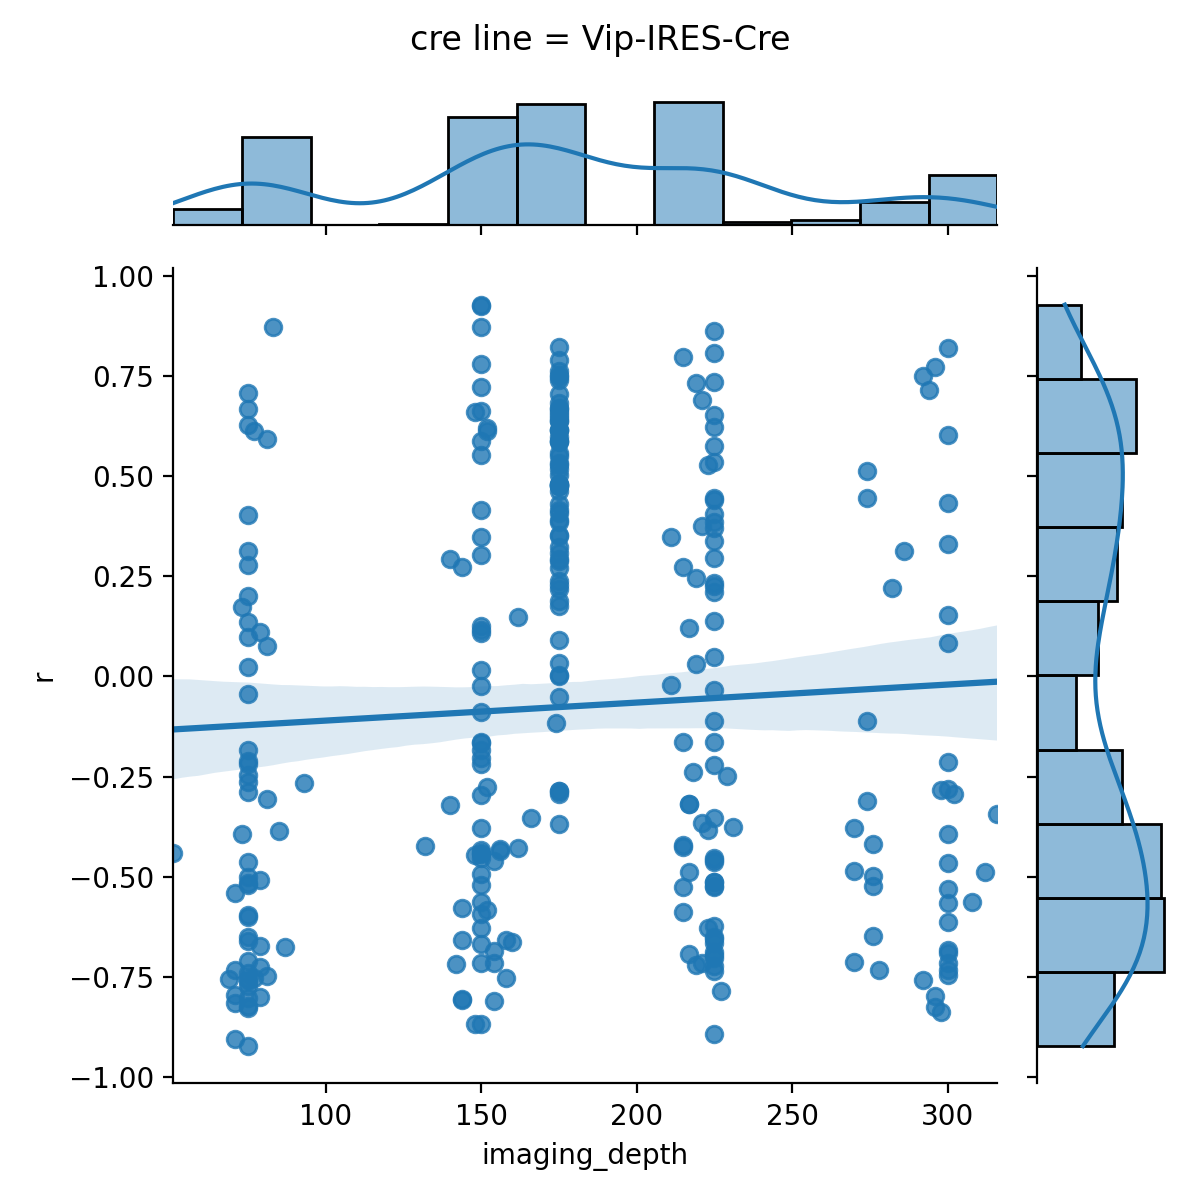

In [261]:
for cre_line in cre_lines:
    
    jp = sns.jointplot(
        data = corr_df.query('cre_line == "{}" and session_type_simple not in ["OPHYS_2", "OPHYS_5"]'.format(cre_line)),
        x = 'imaging_depth',
        y = 'r',
        kind="reg"
    )
    jp.fig.suptitle('cre line = {}'.format(cre_line))
    jp.fig.tight_layout()

In [291]:
480/30

16.0

<IPython.core.display.Javascript object>


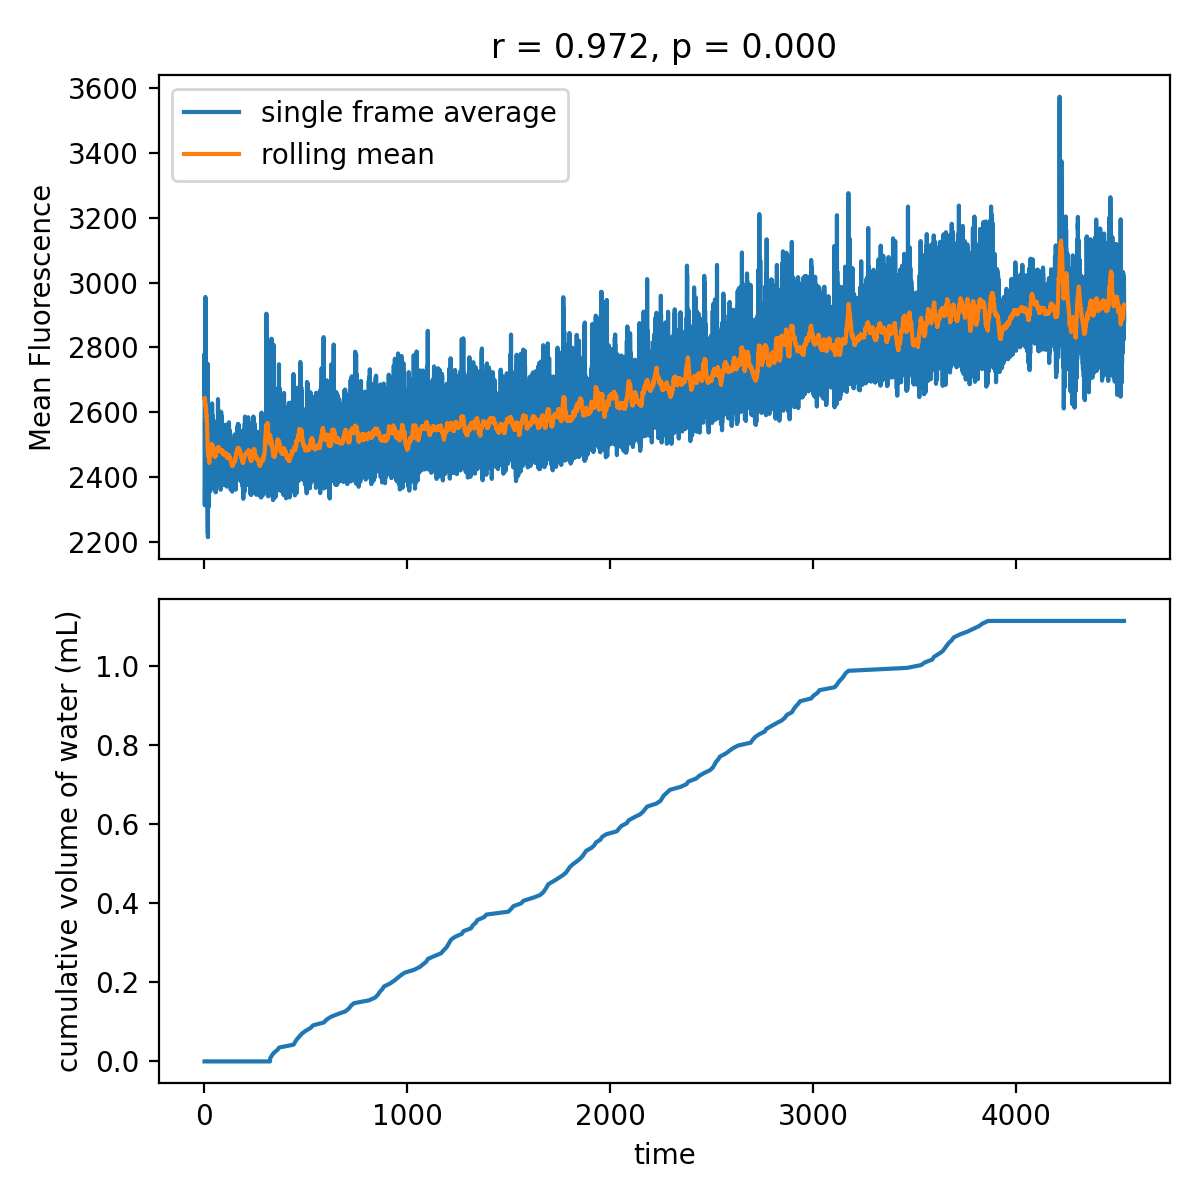

<IPython.core.display.Javascript object>


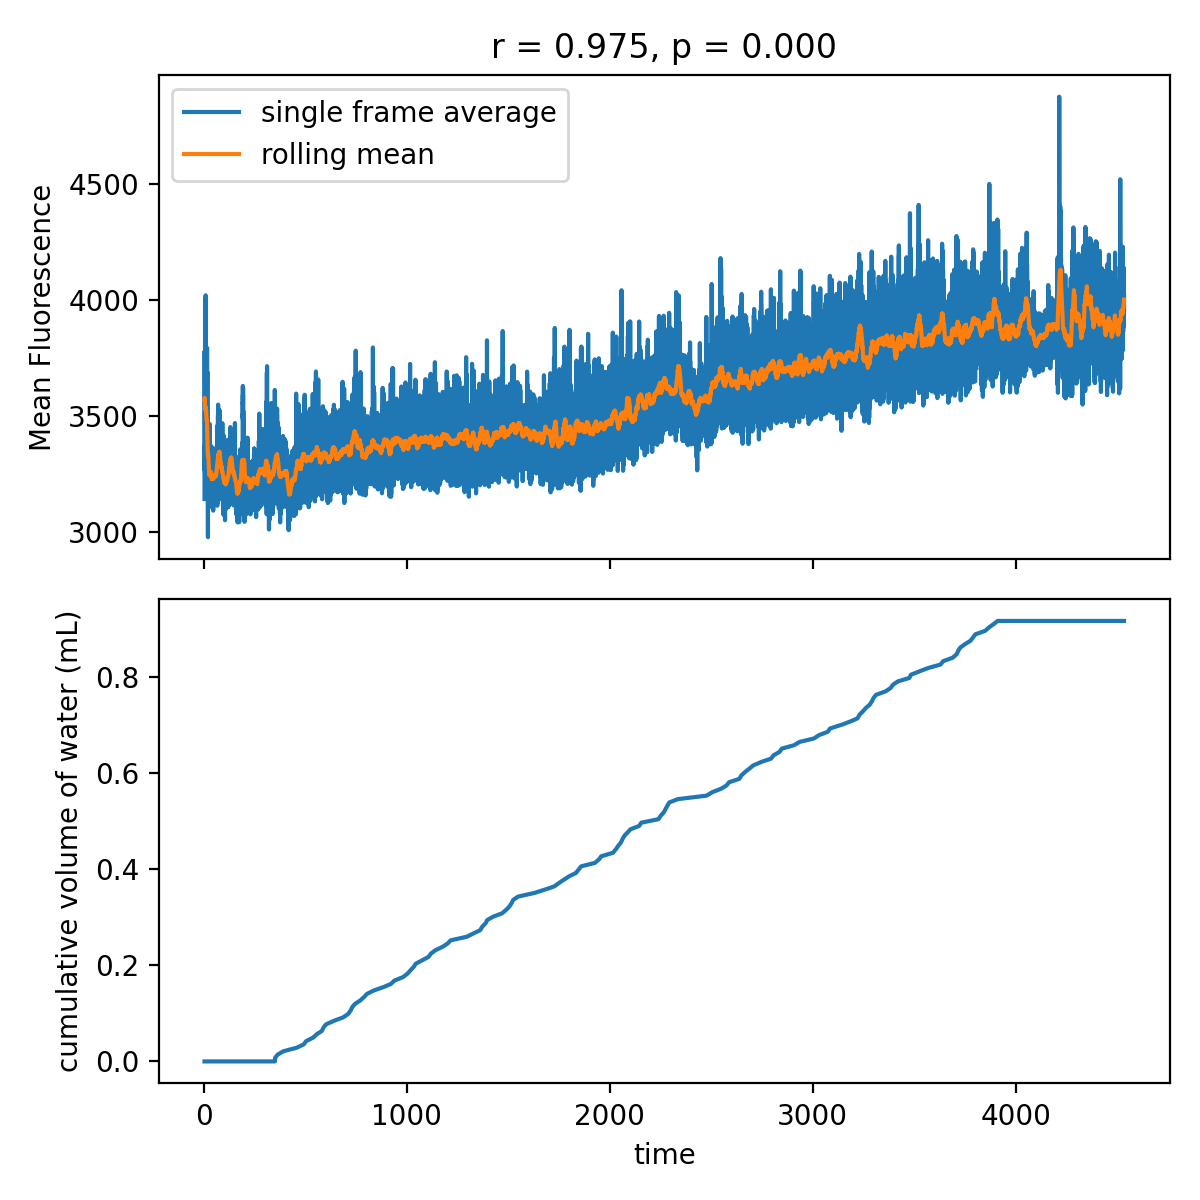

<IPython.core.display.Javascript object>


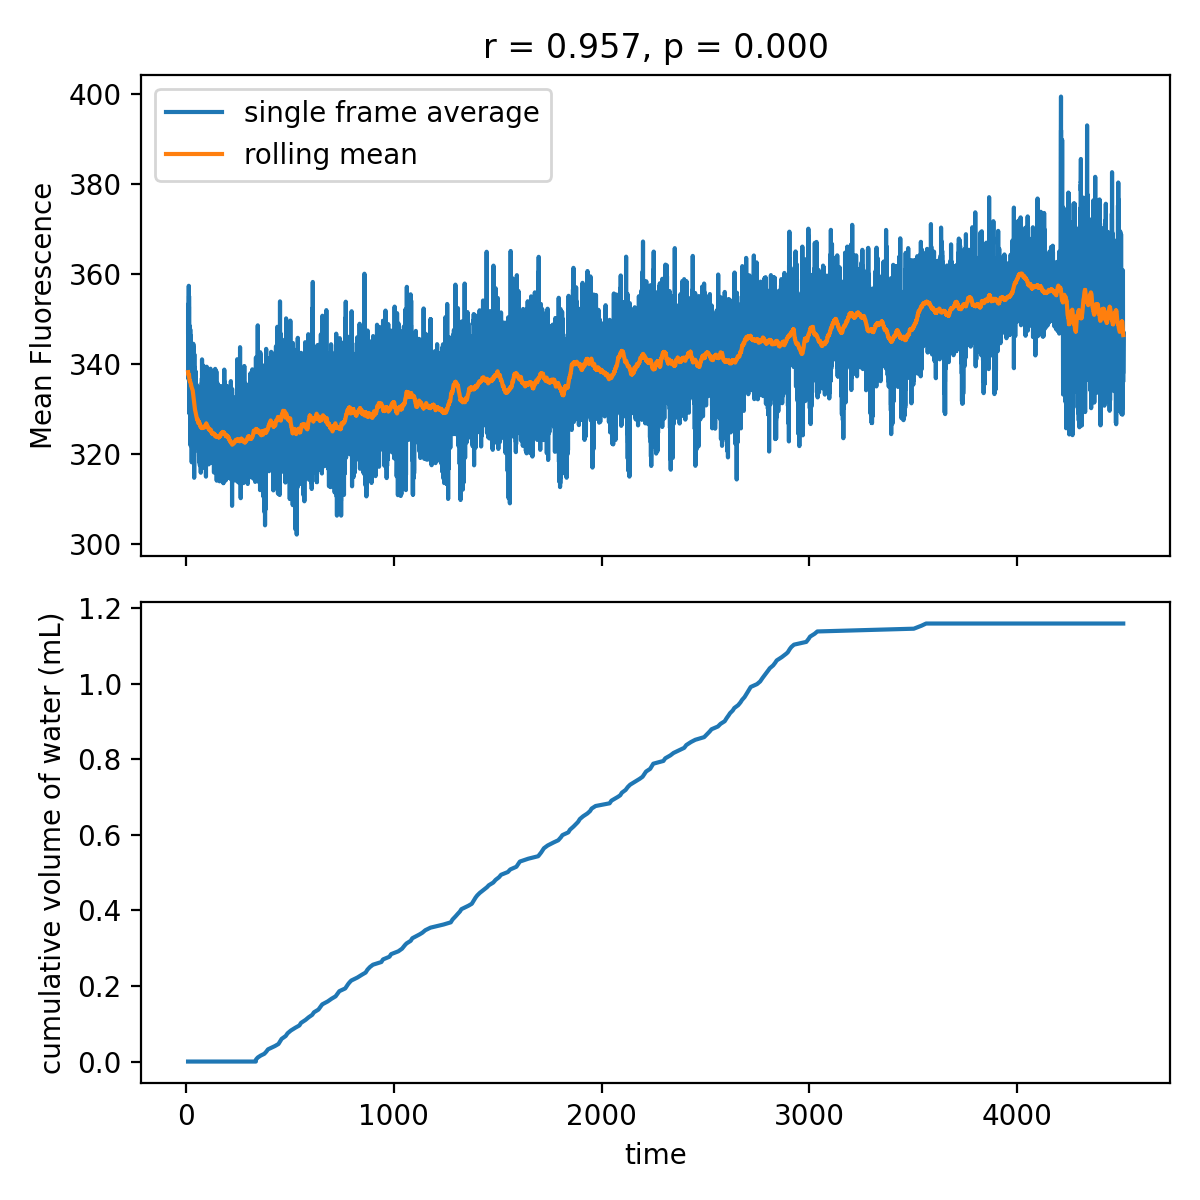

<IPython.core.display.Javascript object>


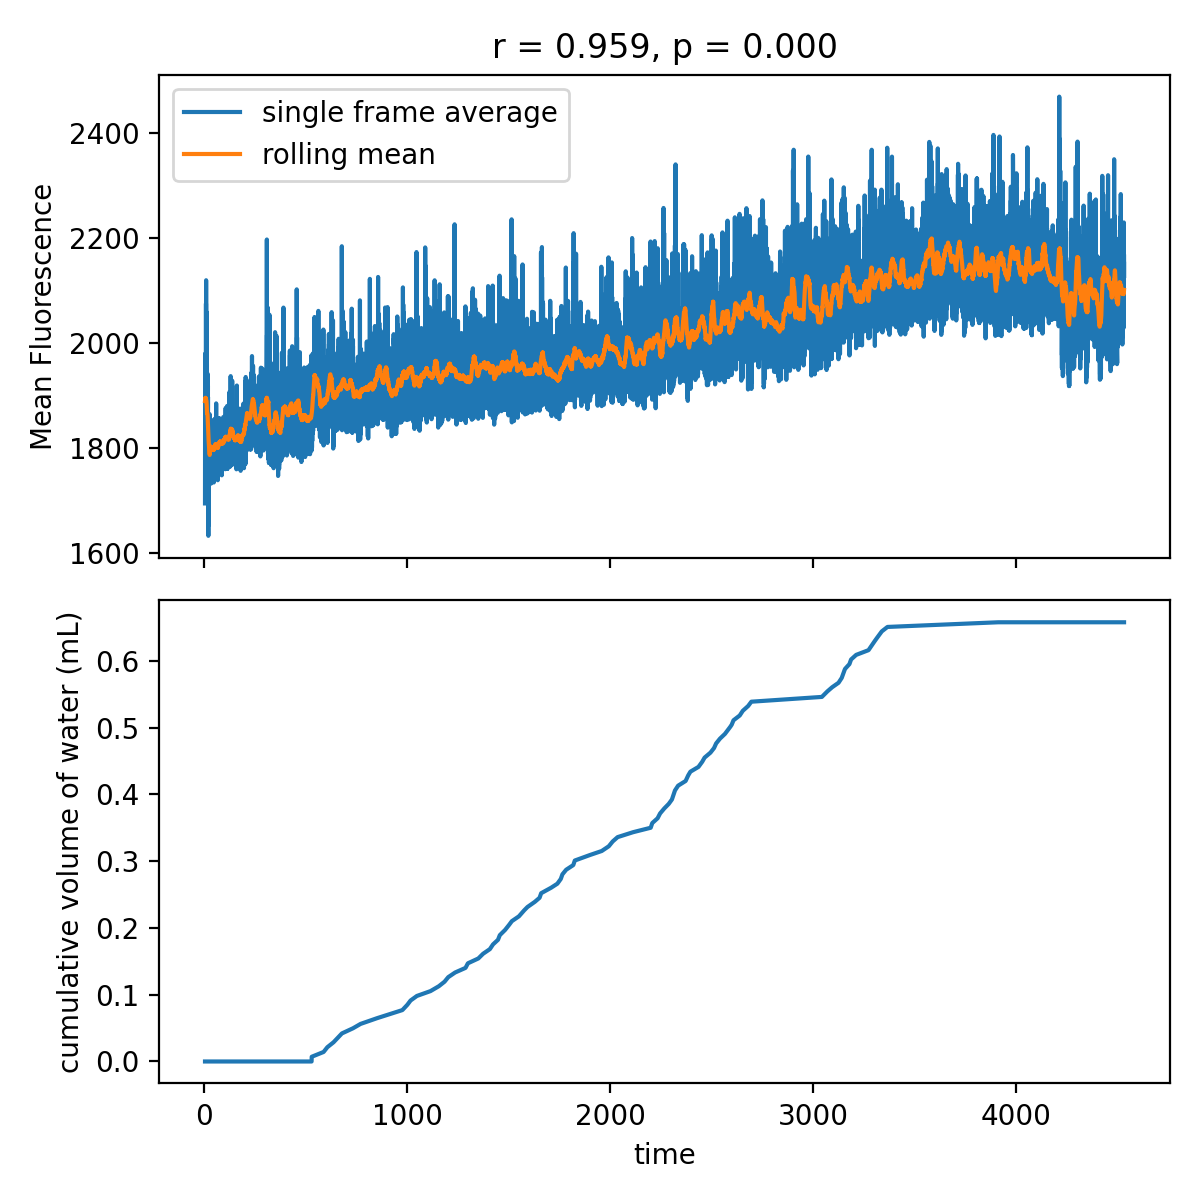

<IPython.core.display.Javascript object>


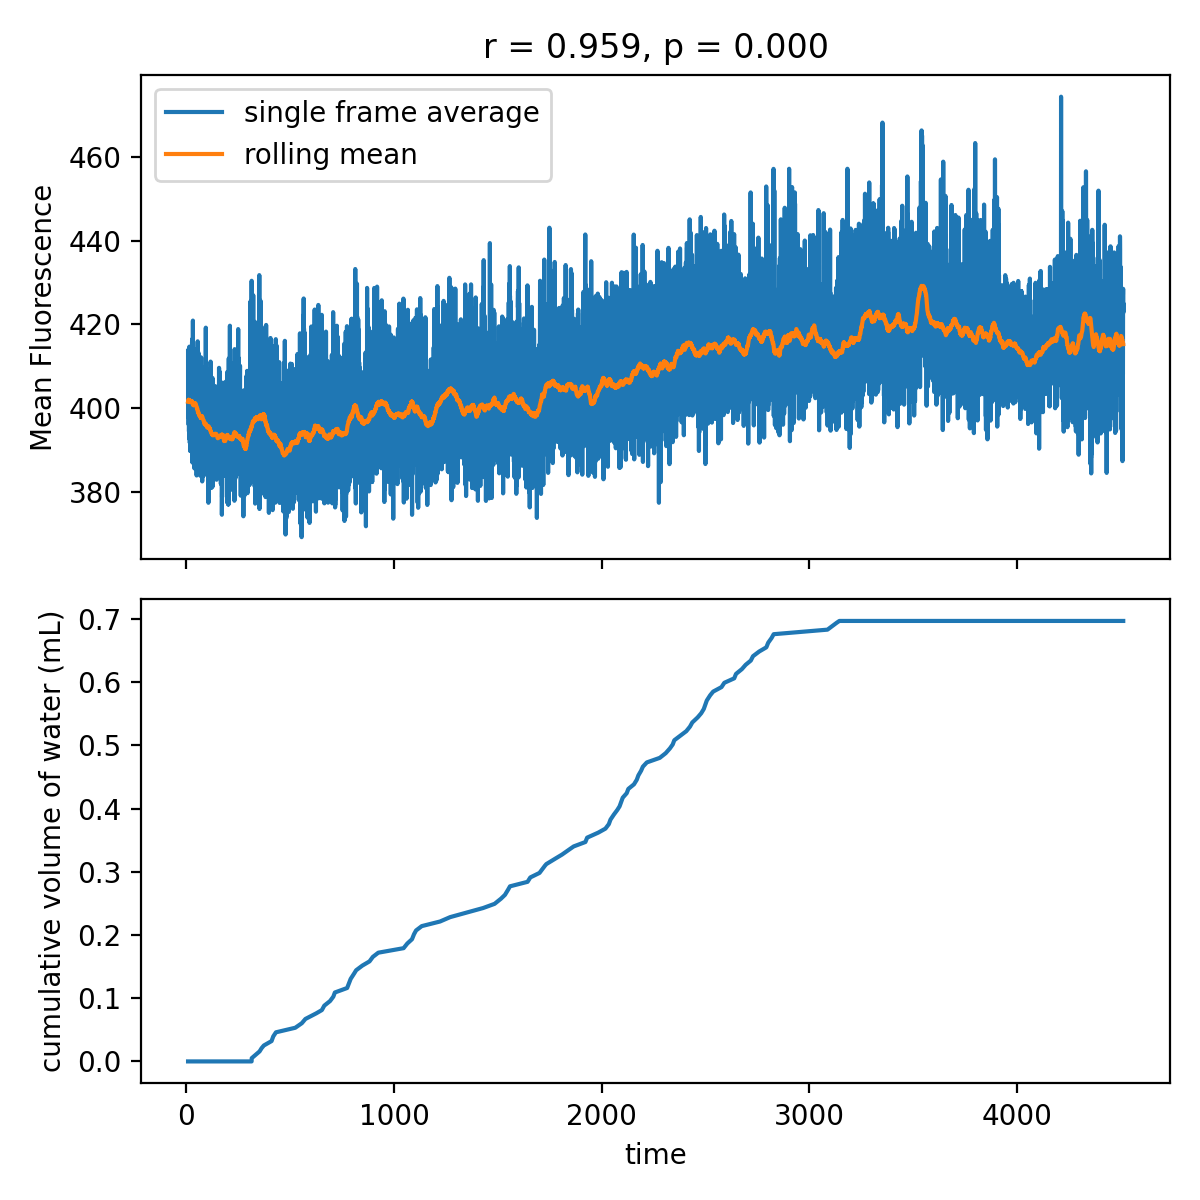

In [266]:
for idx, row in corr_df.query('r > 0.95').sample(5, random_state = 0).iterrows():
    oeid = int(row['ophys_experiment_id'])
    mean_f = mean_fluorescence.retrieve_mean_fluorescence(oeid)
    make_plot(mean_f)

<IPython.core.display.Javascript object>


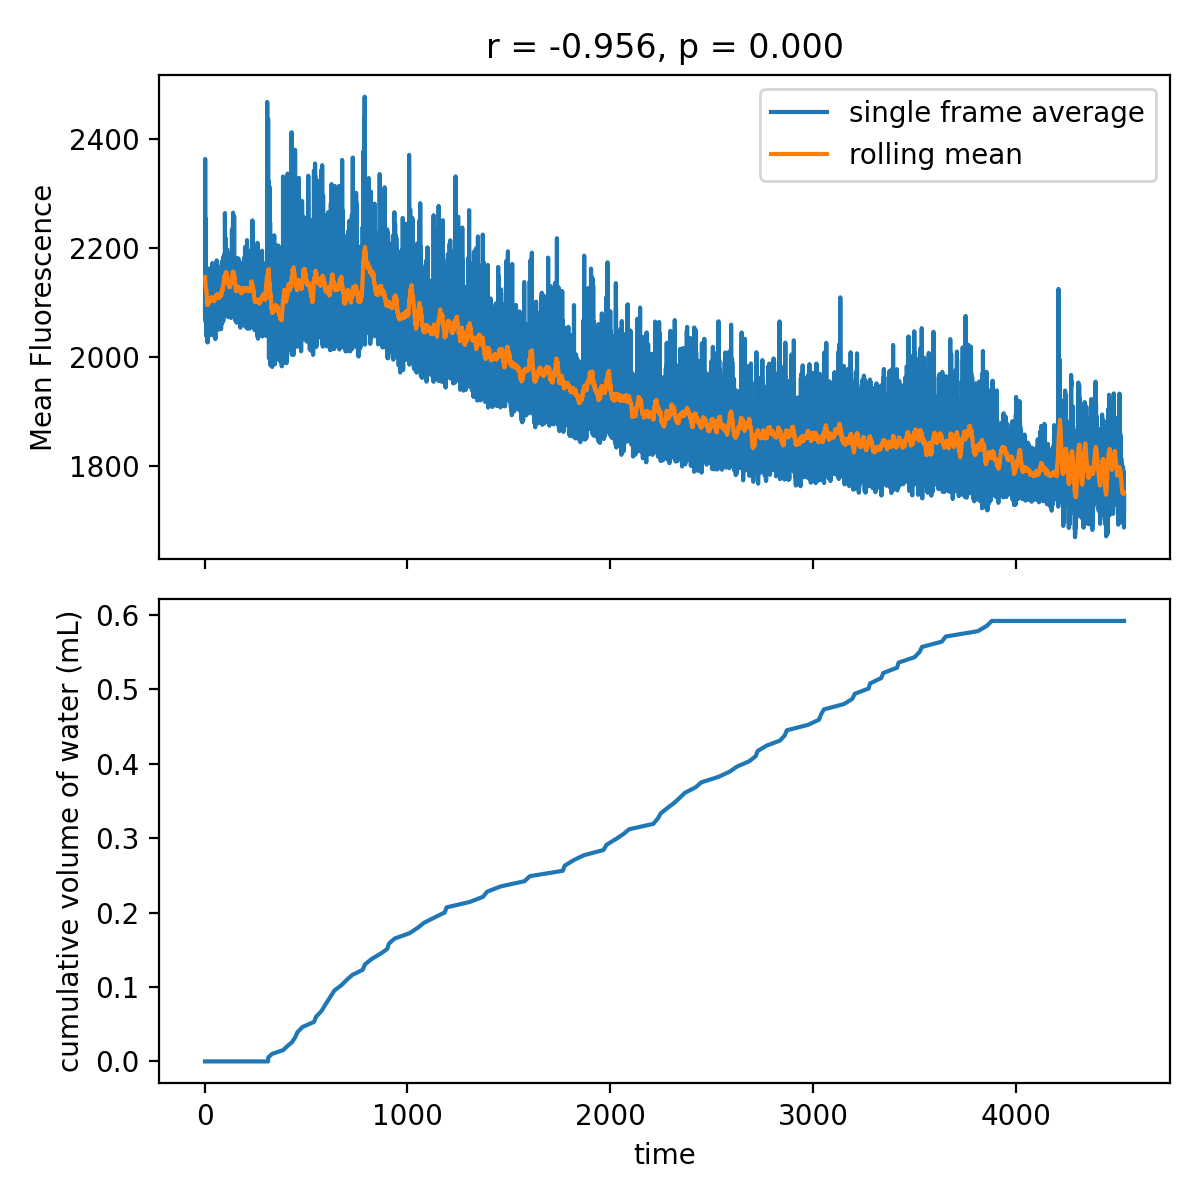

<IPython.core.display.Javascript object>


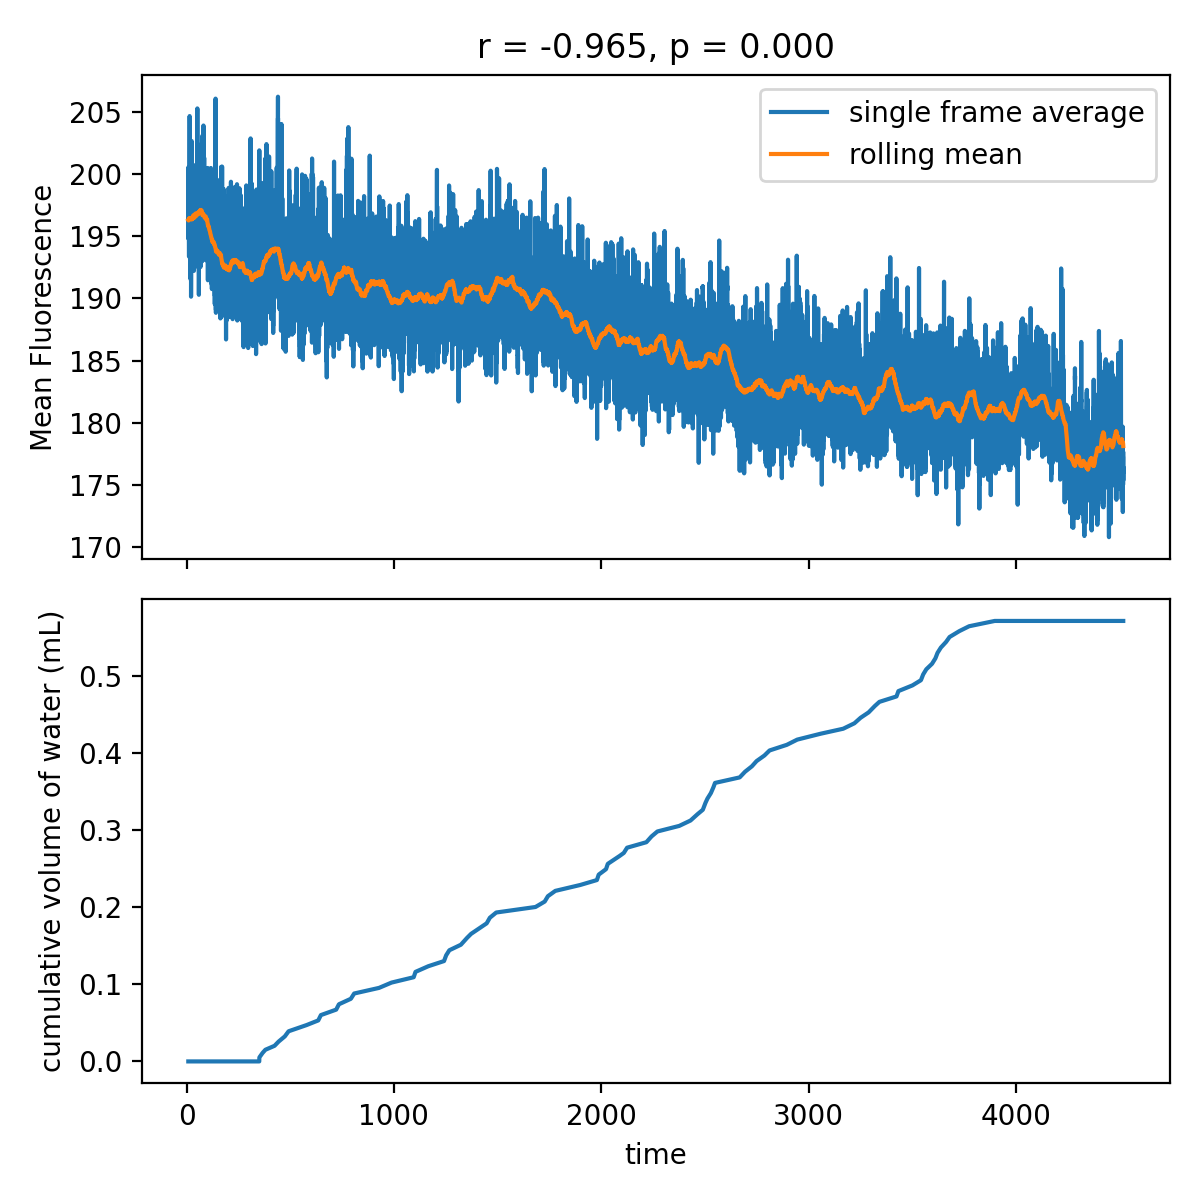

<IPython.core.display.Javascript object>


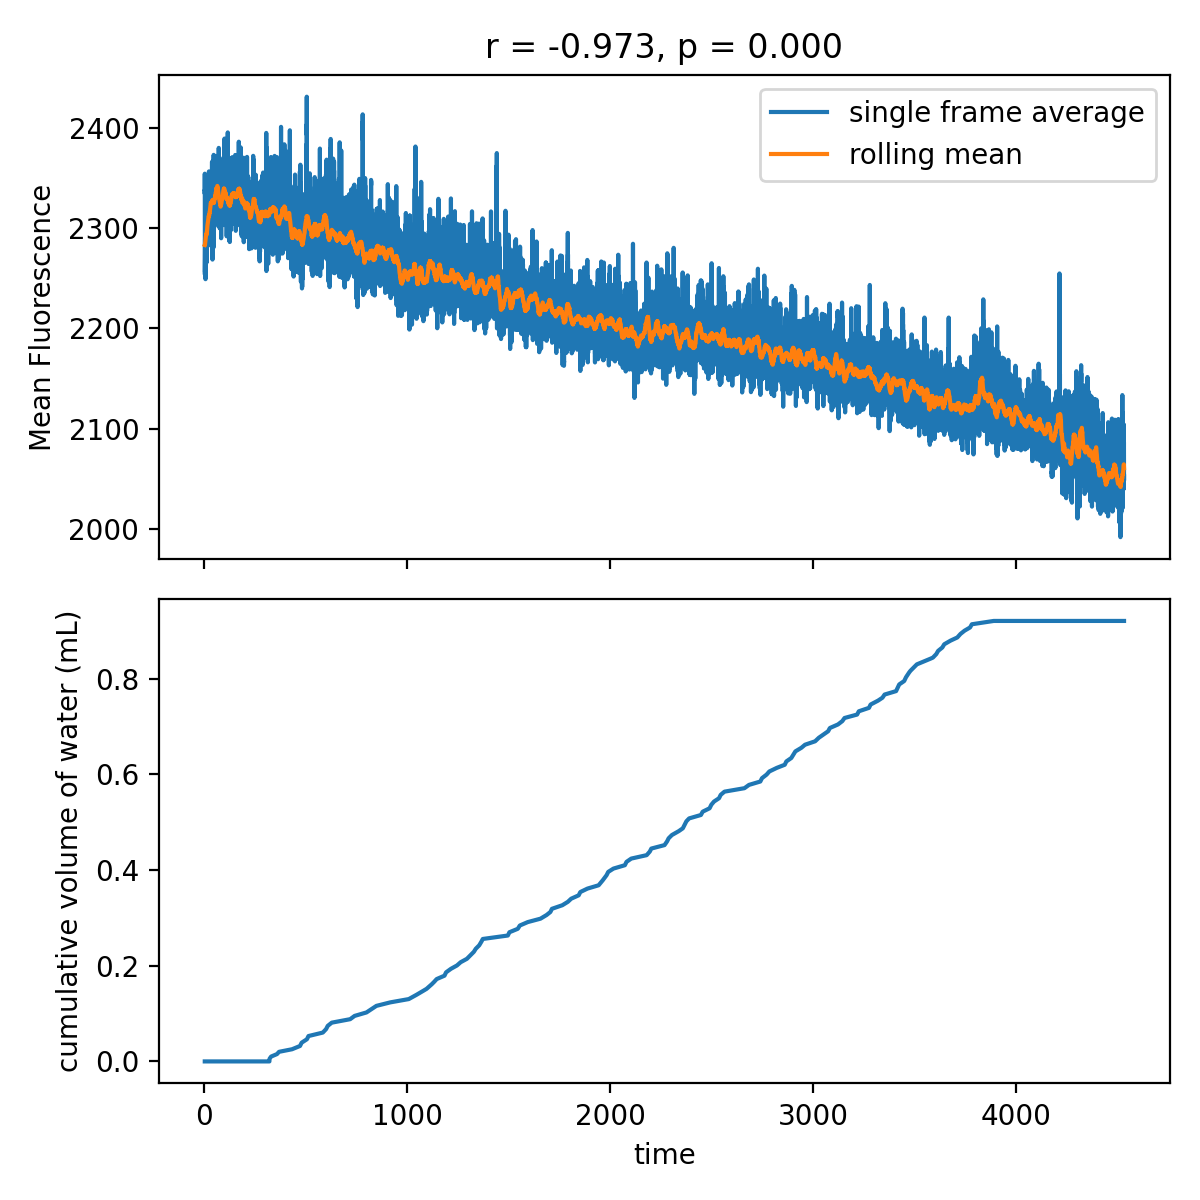

<IPython.core.display.Javascript object>


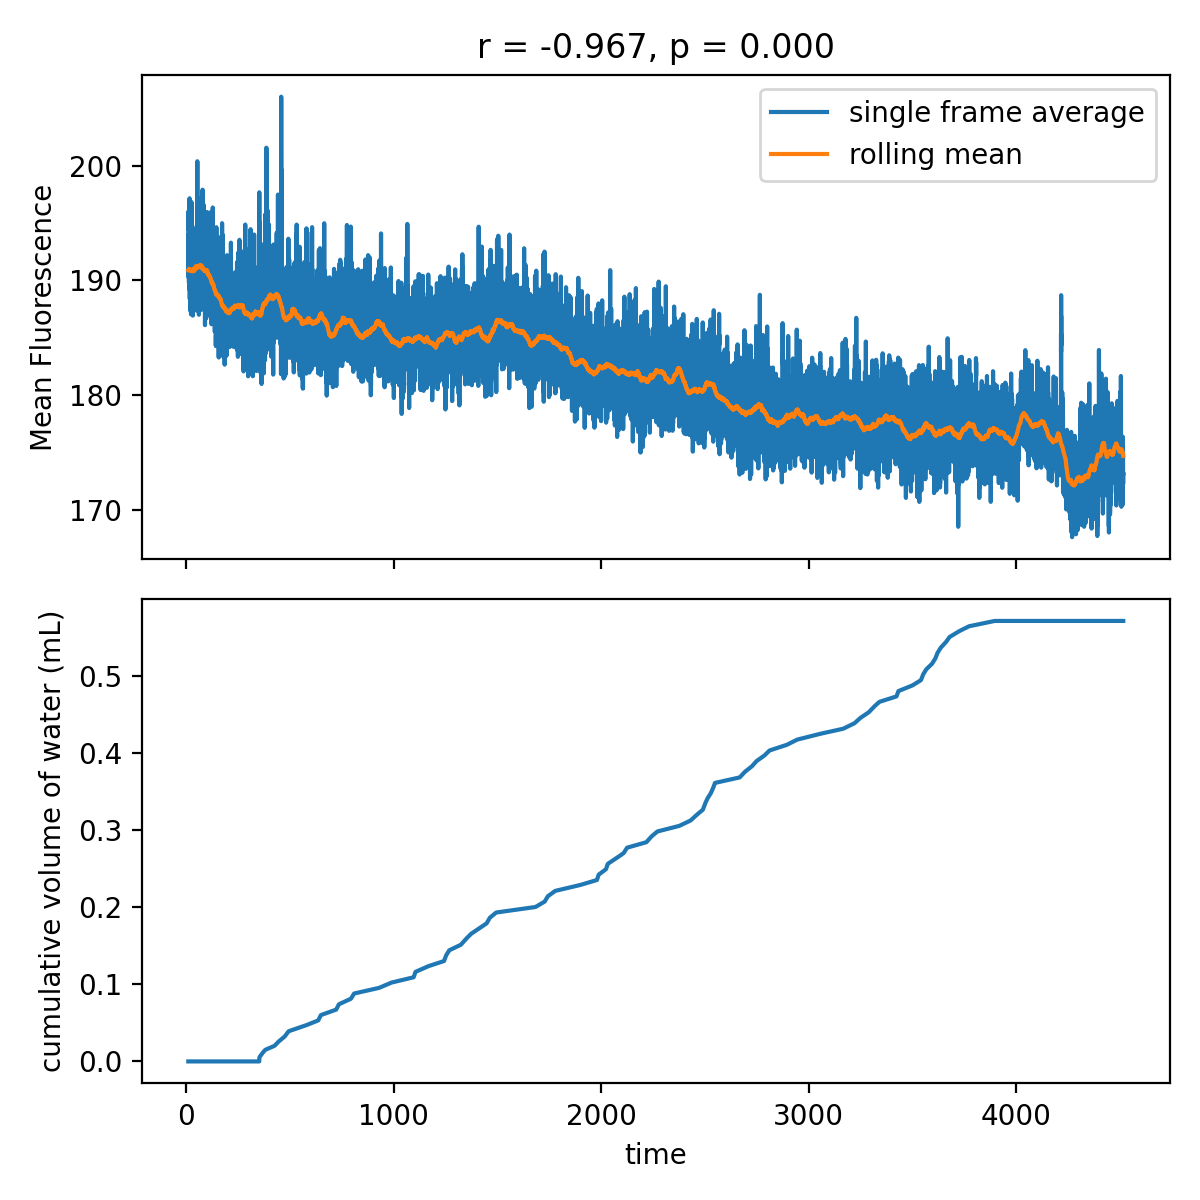

<IPython.core.display.Javascript object>


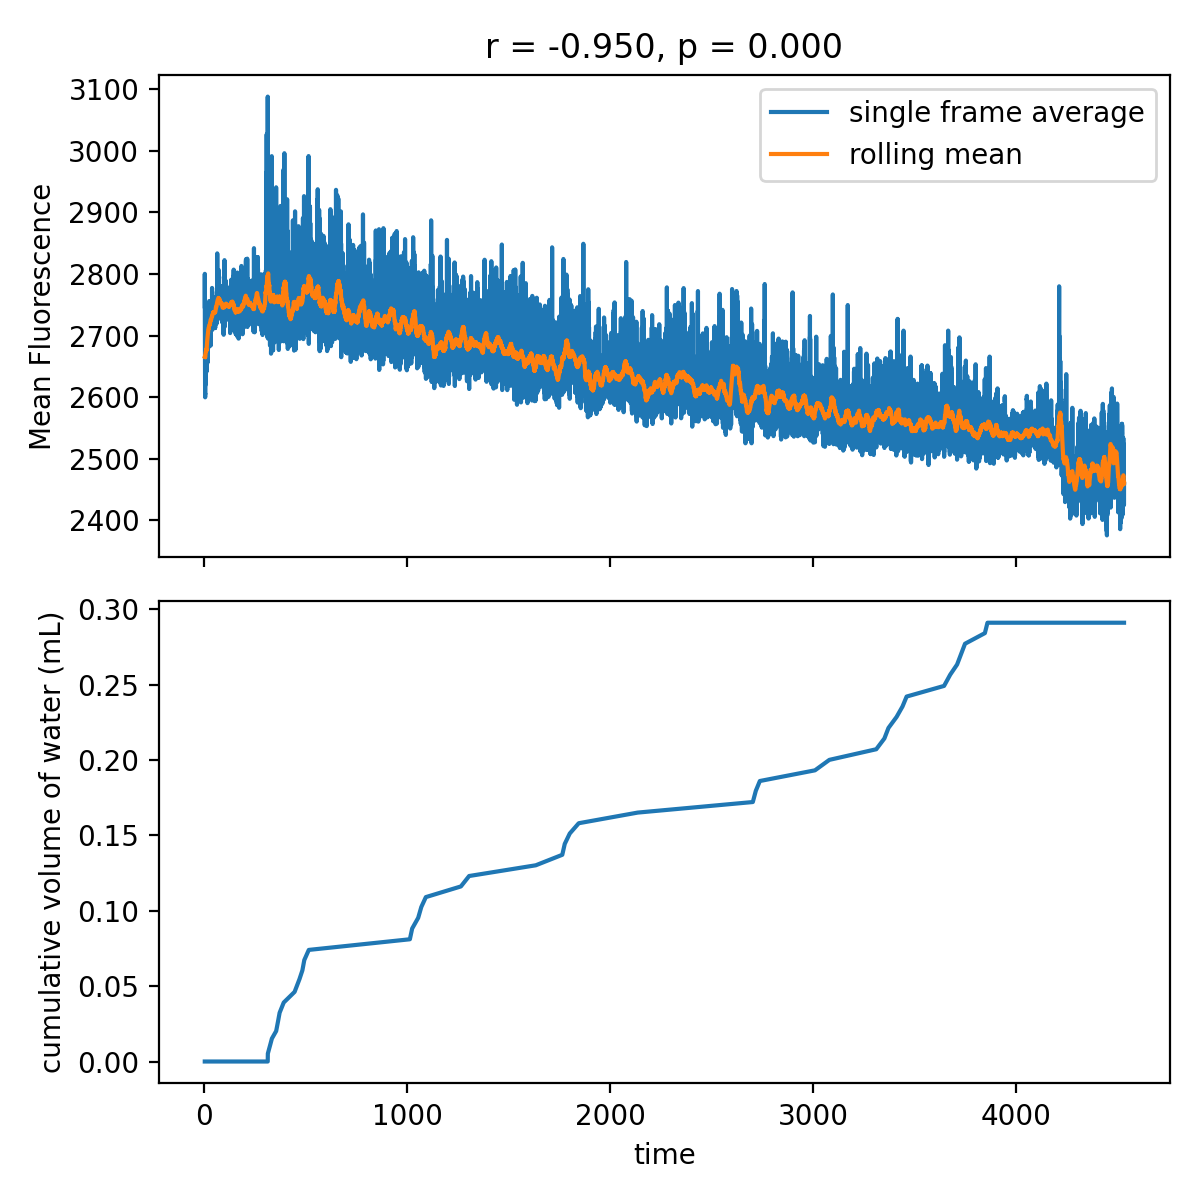

In [267]:
for idx, row in corr_df.query('r < -0.95').sample(5, random_state = 0).iterrows():
    oeid = int(row['ophys_experiment_id'])
    mean_f = mean_fluorescence.retrieve_mean_fluorescence(oeid)
    make_plot(mean_f)

<IPython.core.display.Javascript object>


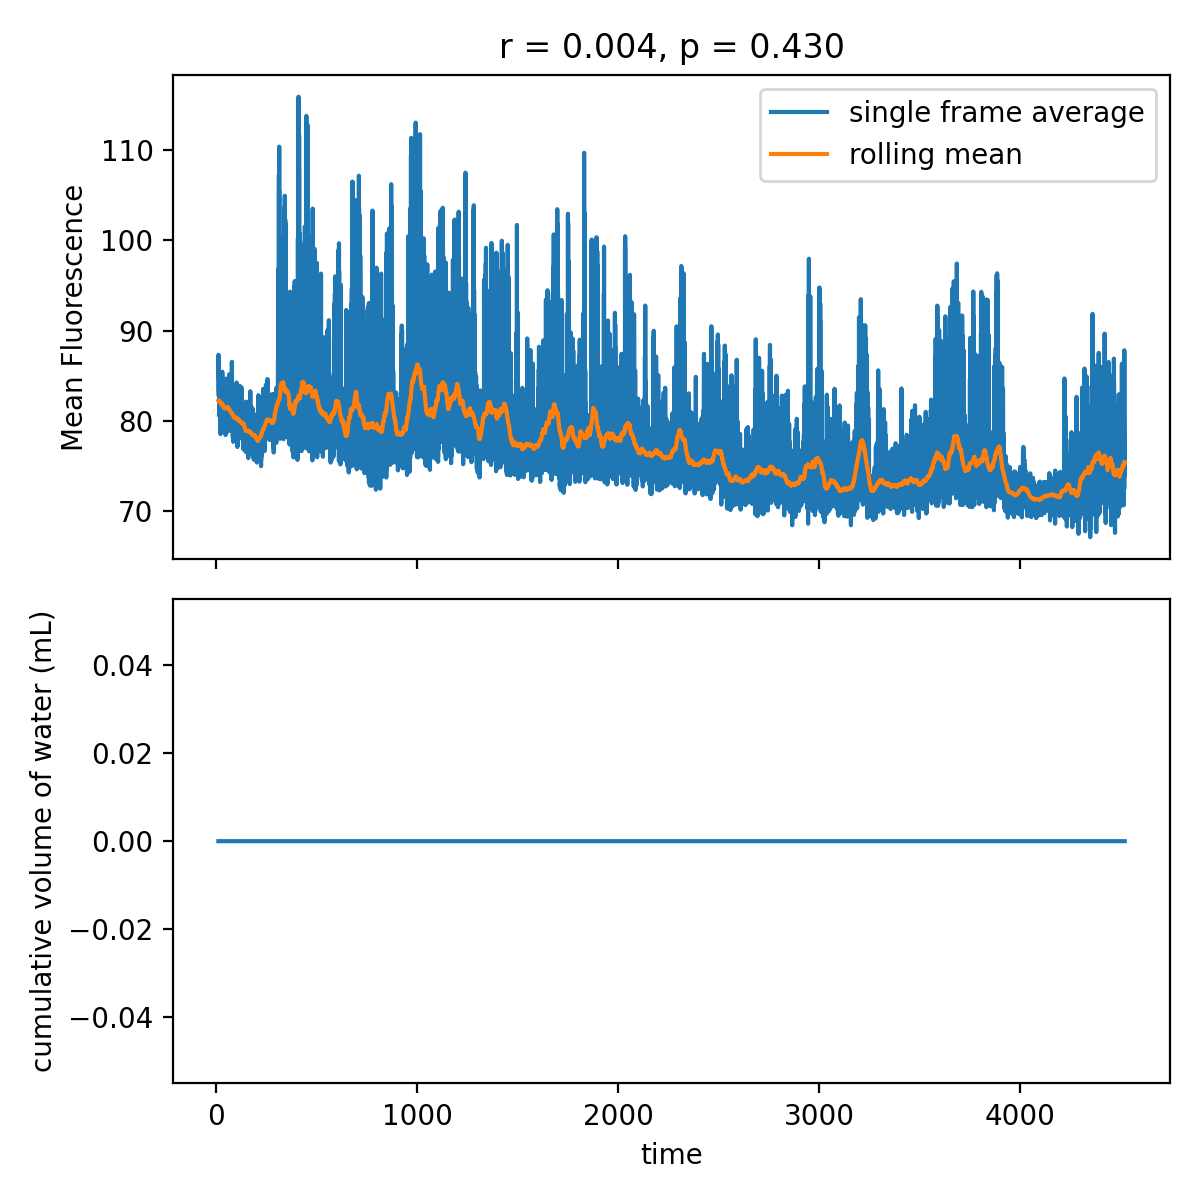

<IPython.core.display.Javascript object>


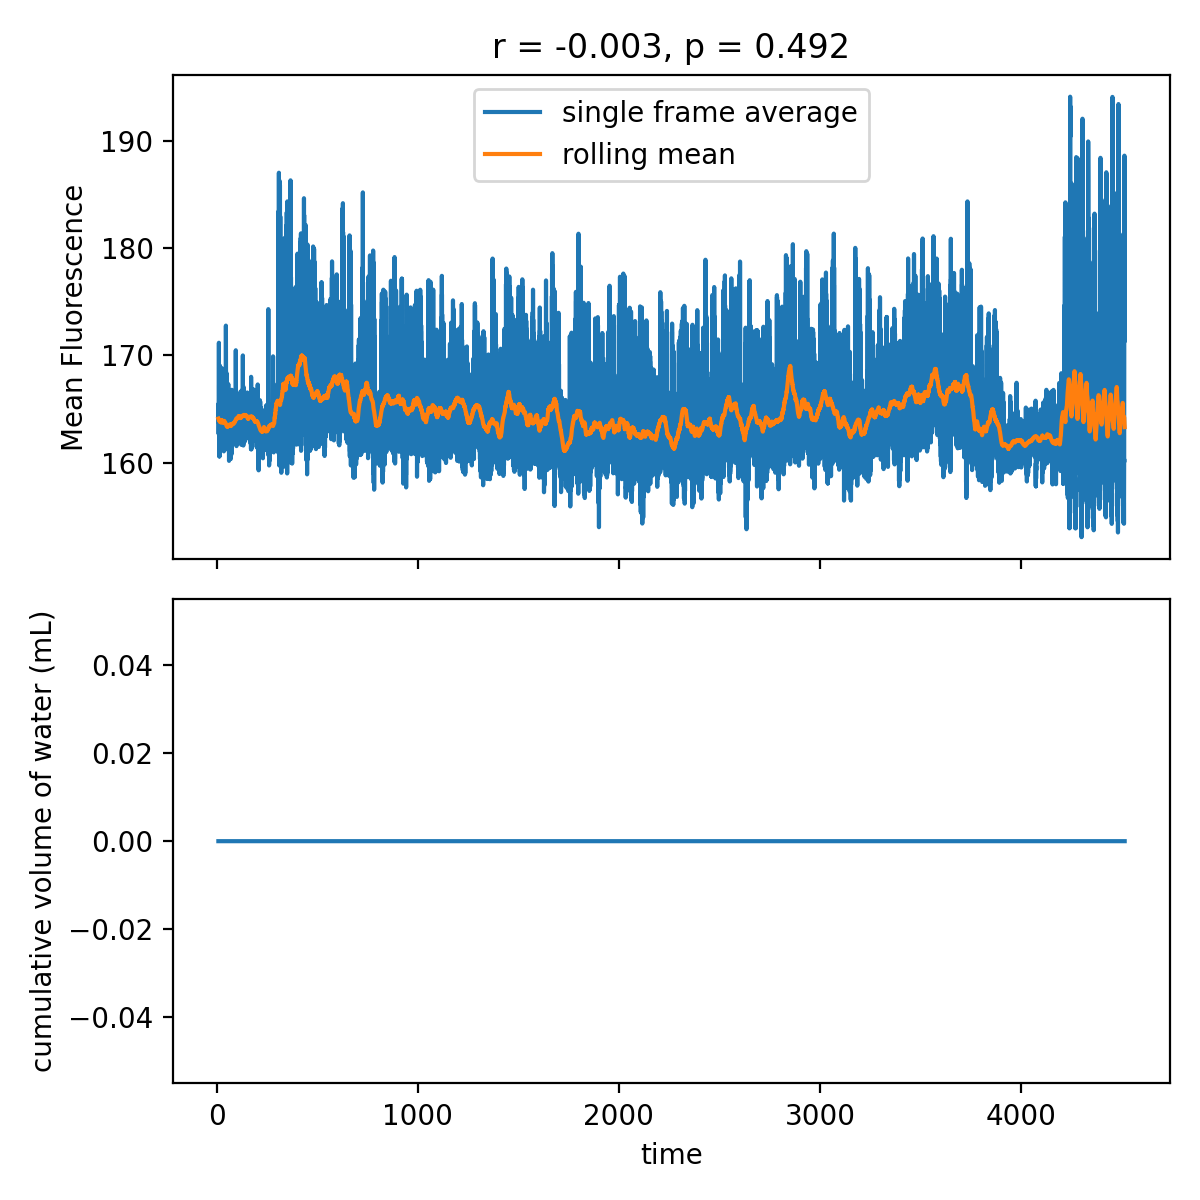

<ipython-input-247-a26923afa661>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(2, 1, sharex=True, figsize = (6,6))


<IPython.core.display.Javascript object>


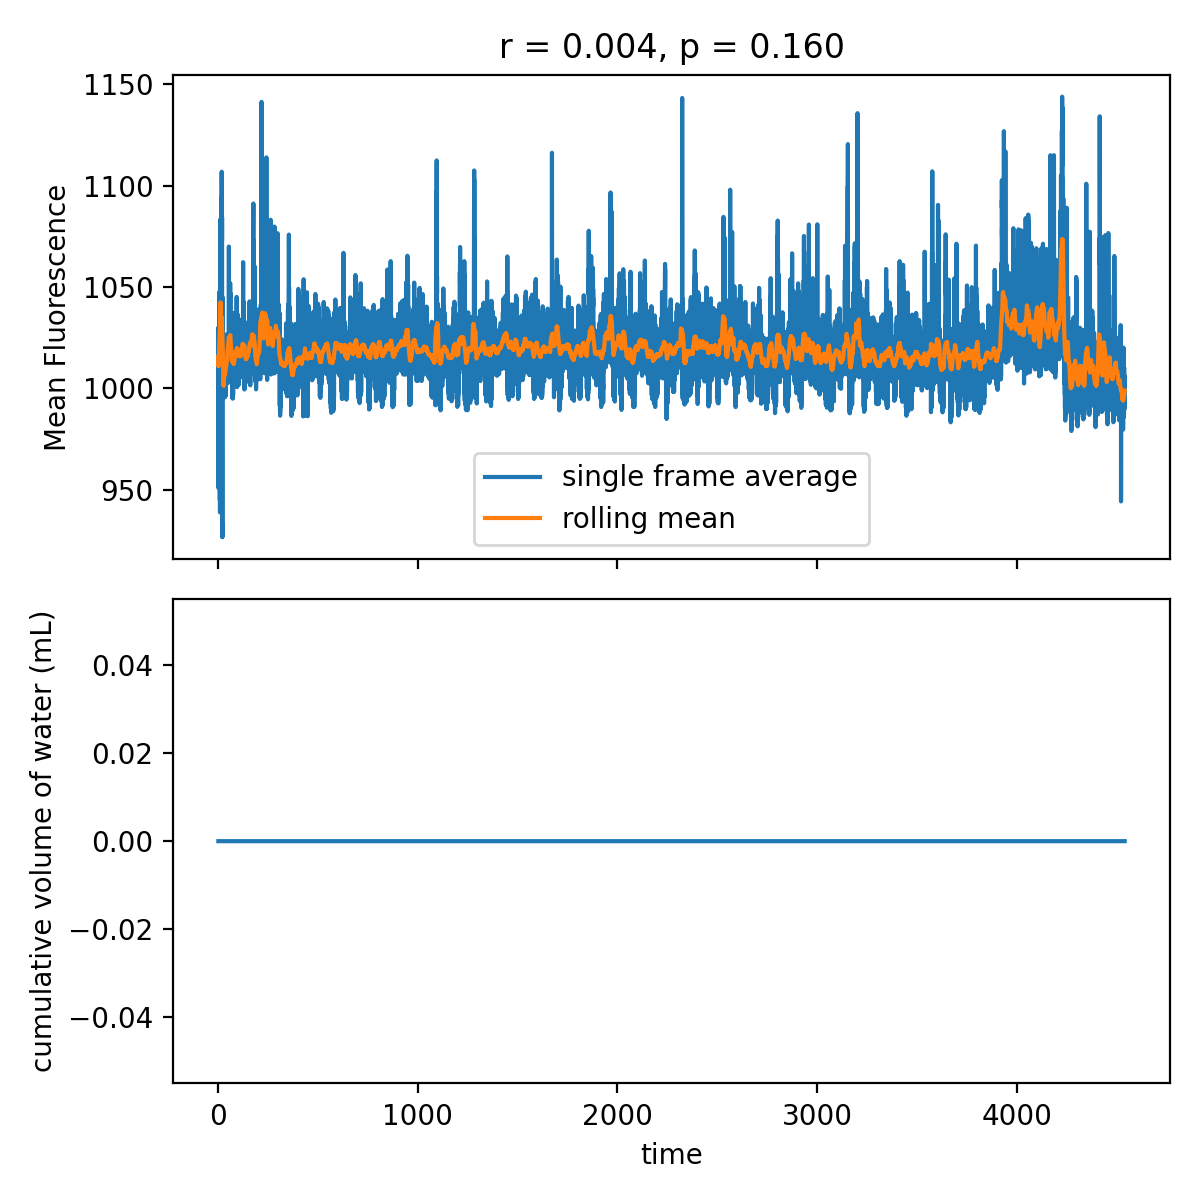

<IPython.core.display.Javascript object>


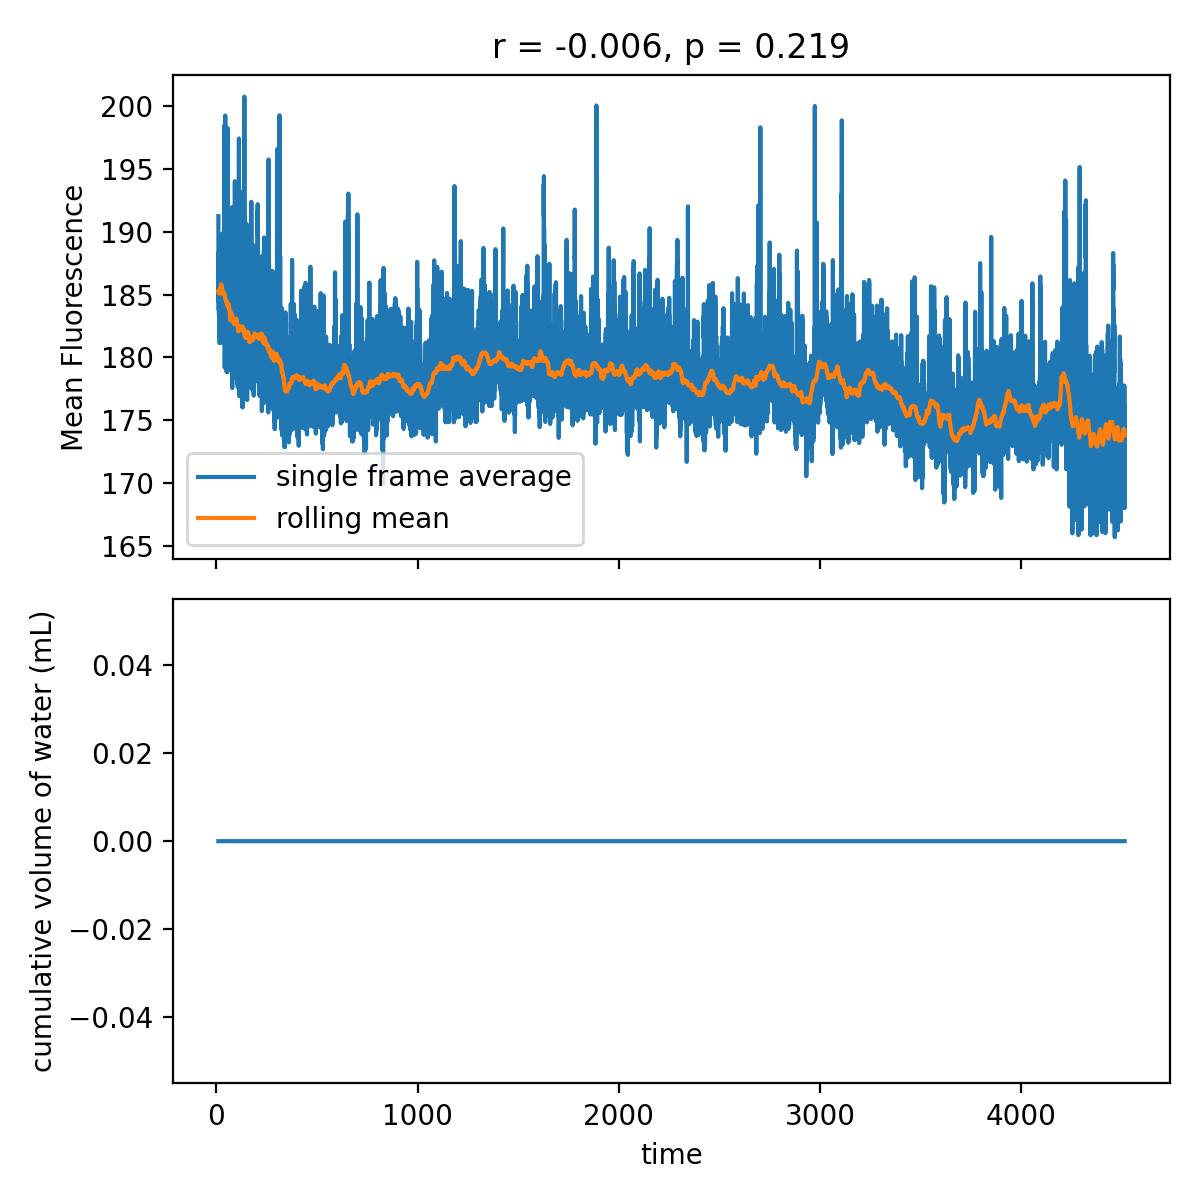

<IPython.core.display.Javascript object>


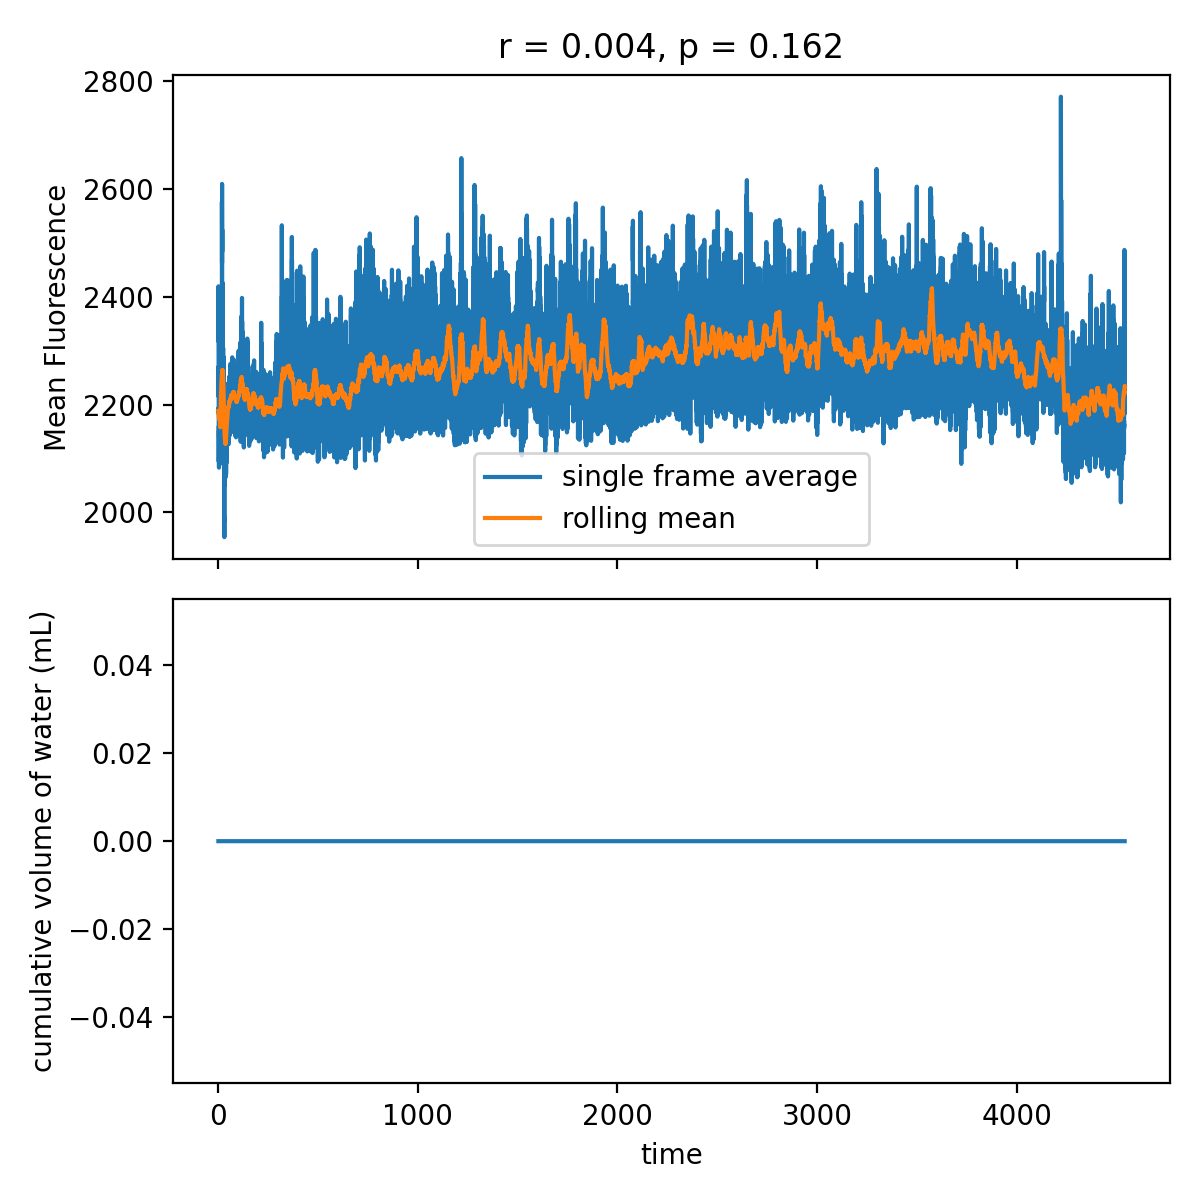

In [268]:
for idx, row in corr_df.query('r < 0.01 and r > -0.01').sample(5, random_state = 0).iterrows():
    oeid = int(row['ophys_experiment_id'])
    mean_f = mean_fluorescence.retrieve_mean_fluorescence(oeid)
    make_plot(mean_f)